In [1]:
# Importing necessary libraries
import requests
import pandas as pd
import re
import numpy as np
from datetime import datetime, timedelta
import time
import json
import os
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibrationDisplay
import joblib
import wandb
import shap
import torch
from torch import nn

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **1. Data Acquisition**

**Code below defines base URL, and other key attributes like number of games, game type (regular season vs playoff), amongst other options.**

In [ ]:
# Key constants for NHL API
BASE_URL = "https://api-web.nhle.com/v1/gamecenter/"
years = [str(year) for year in range(2016, 2021)]  # range of seasons from 2016 to 2024
game_type = {'regular_season': '02', 'playoffs': '03'}  # game types
# Map the number of games for each season for regular season
num_games = {
    '2016': 1230, '2017': 1271, '2018': 1271, '2019': 1082,
    '2020': 868, '2021': 1312}
# Generate game IDs for each season
game_ids = {year: [f"{year}{game_type['regular_season']}{str(game).zfill(4)}" for game in range(1, num_games[year] + 1)] for year in years}
num_rounds = 4
num_games_playoffs = 7
number_series = {1 : 8,
                 2 : 4,
                 3 : 2,
                 4 : 1}

# Generate game IDs for playoffs
game_ids_playoffs = {}
for year in years:
    game_ids_playoffs[year] = []
    for round_num in range(1, num_rounds + 1):
        for series in range(1, number_series[round_num] + 1):
            for game in range(1, num_games_playoffs + 1):
                game_id = f"{year}{game_type['playoffs']}{str(round_num).zfill(2)}{str(series)}{str(game)}"
                game_ids_playoffs[year].append(game_id)

In [ ]:
game_ids_playoffs['2016'][0]

In [ ]:
# Generate all URLs for regular season and playoffs
urls = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids[year]] for year in years}
urls_playoffs = {year: [f"{BASE_URL}{game_id}/play-by-play" for game_id in game_ids_playoffs[year]] for year in years}

In [ ]:
num_games_total = sum(len(v) for v in urls.values()) + sum(len(v) for v in urls_playoffs.values())
num_games_total

**Creating NHLDataFetcher class which handles data fetching and processing for the NHL regular season and playoffs via the use of urls**

In [ ]:
# Create a class to handle NHL data fetching and processing
class NHLDataFetcher:
    def __init__(self, base_url, urls, urls_playoffs):
        self.base_url = base_url
        self.urls = urls
        self.urls_playoffs = urls_playoffs

    def fetch_data(self, url):
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data from {url}: {e}")
            return None


    def process_game_data(self, data : Dict):
        if not data:
            return None

        # Normalize the plays data
        plays_df = pd.json_normalize(data['plays'])

        # Extract and add game info columns
        game_info = {
            'id': data.get('id'),
            'season': data.get('season'),
            'gameDate': data.get('gameDate'),
            'homeTeam_id': data.get('homeTeam', {}).get('id'),
            'homeTeam_abbrev': data.get('homeTeam', {}).get('abbrev'),
            'homeTeam_commonName_default': data.get('homeTeam', {}).get('commonName', {}).get('default'),
            'awayTeam_id': data.get('awayTeam', {}).get('id'),
            'awayTeam_abbrev': data.get('awayTeam', {}).get('abbrev'),
            'awayTeam_commonName_default': data.get('awayTeam', {}).get('commonName', {}).get('default')
        }

        plays_df = plays_df.assign(**game_info)
        plays_df.rename(columns = lambda col : col.replace('.', '_'), inplace=True)


        # Select only the desired columns
        desired_columns = [
            'id', 'season', 'gameDate',
            'homeTeam_id', 'homeTeam_abbrev', 'homeTeam_commonName_default',
            'awayTeam_id', 'awayTeam_abbrev', 'awayTeam_commonName_default',
            'eventId', 'periodDescriptor_number', 'periodDescriptor_periodType',
            'timeInPeriod', 'timeRemaining', 'typeCode', 'typeDescKey',
            'details_xCoord', 'details_yCoord', 'details_zoneCode', 'details_shotType',
            'details_shootingPlayerId', 'details_scoringPlayerId', 'details_goalieInNetId',
            'details_eventOwnerTeamId', 'situationCode', 'details_emptyNet', 'details_penaltyMinutes', 'details_penaltySeverityCode'
        ]

        plays_df = plays_df.reindex(columns=desired_columns)

        return plays_df

    def process_all_games(self, urls_dict):
        dfs = []
        for year, urls in urls_dict.items():
            len_urls = len(urls)
            print(f"Processing games of year {year}")
            for idx, url in enumerate(urls):
                data = self.fetch_data(url)
                game_df = self.process_game_data(data)
                if game_df is not None:
                    dfs.append(game_df)
                time.sleep(0.1)  # To avoid hitting the API rate limit
                batch_idx = (idx + 1) / len_urls * 100
                if batch_idx.is_integer() and batch_idx % 10 == 0 and batch_idx >= 1:
                    print(f"Processed {(idx + 1)} out of {len_urls} games ({(batch_idx):.2f}%)")
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        else:
            return pd.DataFrame()



**Testing URL and NHLDataFetcher Class**

In [ ]:
# Pick a random URL to test
test_url = urls['2016'][0] # First game of the 2023 season
test_url_playoffs = urls_playoffs['2016'][0]
test_url, test_url_playoffs

# Initialize the data fetcher
data_fetcher = NHLDataFetcher(BASE_URL, urls, urls_playoffs)

# Test with a sample URL for fetching data for a single game
sample_data = data_fetcher.fetch_data(test_url)
sample_df = data_fetcher.process_game_data(sample_data)
print(sample_df.head())
print(sample_df['details_penaltyMinutes'].isna().sum(), "NaN values out of", len(sample_df))
print(sample_df['details_penaltyMinutes'].unique())
print(sample_df['details_penaltySeverityCode'].isna().sum(), "NaN values out of", len(sample_df))
print(sample_df['details_penaltySeverityCode'].unique())

In [ ]:
# Processing data for an entire season
season_df = data_fetcher.process_all_games({'2016': urls['2016']})
print(season_df.shape)

**Tidy Data (Creating Pandas Dataframe)**

In [ ]:
# Creating Pandas Dataframe of NHL Data between 2016 - 2021 including both regular season games and playoffs
all_regular_season_df = data_fetcher.process_all_games(urls)
all_playoffs_df = data_fetcher.process_all_games(urls_playoffs)
all_games_df = pd.concat([all_regular_season_df, all_playoffs_df], ignore_index=True)
all_games_df.to_csv('nhl_all_games_data.csv', index=False)

**Exploration of pandas data frame using head(50)**

In [ ]:
all_games_df.head(50)

**Further Exploration of Pandas Dataframe**

In [ ]:
# Futher exploration of the data set
all_games_df['id'].nunique(), all_games_df['season'].nunique(), all_games_df['typeDescKey'].nunique()
all_games_df.info()
all_games_df.describe()

# **2. Feature Engineering**

**a)** **Histograms of Distance and Angles from Net relationship against Goals Scored**

Training and Validation set: (1649172, 26)
Final test set shape: (287926, 26)
   distance_from_net  angle_from_net  is_goal  empty_net    season
5          51.429563       26.565051        0          1  20162017
6          30.083218       21.447736        0          1  20162017
7          13.000000       22.619865        0          0  20162017
8          33.060551        3.468229        0          1  20162017
9          38.078866       13.671307        0          0  20162017


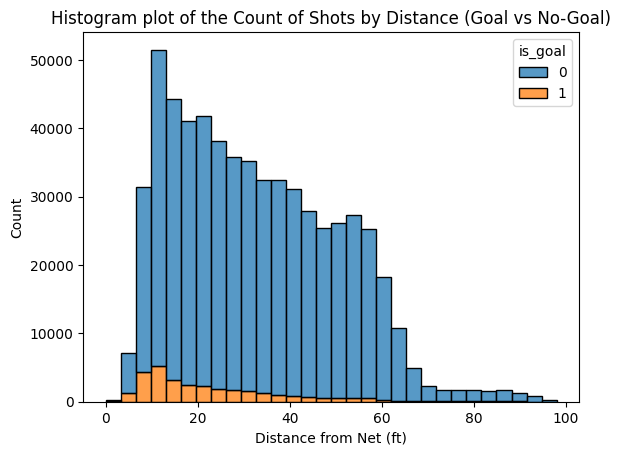

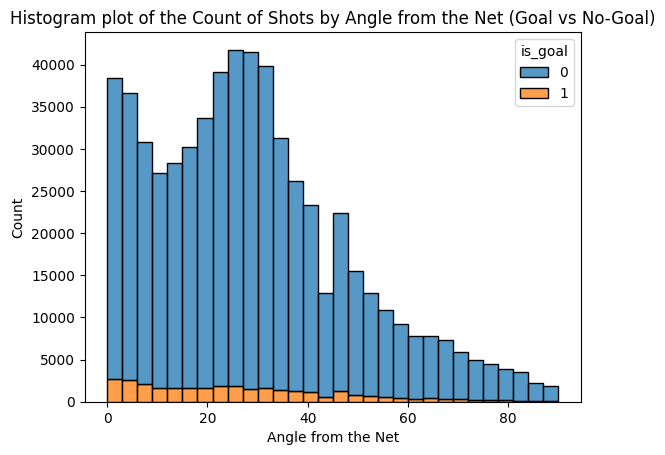

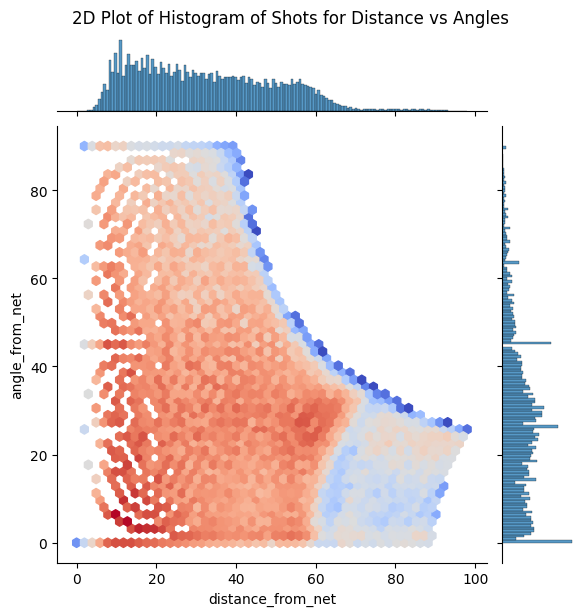

In [2]:
all_games_df = pd.read_csv('nhl_all_games_data.csv')

# 1. Splitting data into training and test sets
# Data for seasons between 2016 to 2020 are training and validation sets, 2020/2021 season data is the data for the final test set
# Defining the training and validation data frame
train_valid_df = all_games_df[all_games_df['season'].astype('str').between('2016','2020')]
test_final_df = all_games_df[all_games_df['season'].astype('str') == '20202021']

# 2. Printing out shapes for training, validation, and test set
print(f"Training and Validation set: {train_valid_df.shape}")
print(f"Final test set shape: {test_final_df.shape}")

# 3. Filtering only on shot-on-goal and goal events
shots_df = train_valid_df[train_valid_df['typeDescKey'].isin(['shot-on-goal', 'goal', 'missed-shot', 'blocked-shot'])].copy()

# 4. Standardizing the direction of all shots to ensure that they face the same net
shots_df['x_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_xCoord'],
                                      shots_df['details_xCoord'])
shots_df['y_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_yCoord'],
                                      shots_df['details_yCoord'])

# 5. Calculate the angles from the net and distance from the net
# We assume that the net can be at the position (89, 0)
def compute_angles_distance(x,y):
  x_net, y_net = 89, 0
  dx = x_net - x
  dy = y_net - y
  # Defining Distance and Angles
  dist = np.sqrt(dx**2 + dy**2)
  # Angles are converted to degrees
  ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
  return dist, ang


# 6. Defining the Shots Data frame
shots_df['distance_from_net'], shots_df['angle_from_net'] = zip(*shots_df.apply(lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]), axis=1))

# 7. Creating the Is Goal and Empty Net column
shots_df["is_goal"] = np.where(shots_df["typeDescKey"]== "goal", 1, 0)
shots_df["empty_net"] = np.where(
    shots_df["details_goalieInNetId"].isna(), 1, 0
)


# 8. Selecting the final tidy data set for shots
tidy_shots_data = shots_df[['distance_from_net', 'angle_from_net', 'is_goal', 'empty_net', 'season']]
# Printing tidy shots table
print(tidy_shots_data.head())

# 9. Visualizations
# a) Histogram of shot counts (goals and no goals separated) binned by distance
sns.histplot(data=tidy_shots_data, x="distance_from_net", hue="is_goal", multiple='stack', bins=30)
plt.title("Histogram plot of the Count of Shots by Distance (Goal vs No-Goal)")
plt.xlabel("Distance from Net (ft)")
plt.ylabel("Count")
plt.show()

# b) Histogram of shot counts (goals and no goals separated) binned by angle
sns.histplot(data=tidy_shots_data, x="angle_from_net", hue="is_goal", multiple="stack", bins=30, palette=['#1f77b4', '#ff7f0e'])
plt.title("Histogram plot of the Count of Shots by Angle from the Net (Goal vs No-Goal)")
plt.xlabel("Angle from the Net")
plt.ylabel("Count")
plt.show()

# c) 2D Plot of Histogram of distance vs angle:
sns.jointplot(data=tidy_shots_data, x="distance_from_net", y="angle_from_net", kind="hex", bins="log", cmap="coolwarm")
plt.suptitle("2D Plot of Histogram of Shots for Distance vs Angles", y=1.02)
plt.show()

In [3]:
print(shots_df["empty_net"].unique())
print(shots_df["empty_net"].value_counts(dropna=False))


[1 0]
empty_net
0    449050
1    152882
Name: count, dtype: int64


**b)** **Angles and Distance Plots Continued**

/tmp/ipykernel_169009/4003250488.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("distance_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
/tmp/ipykernel_169009/4003250488.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("angle_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))


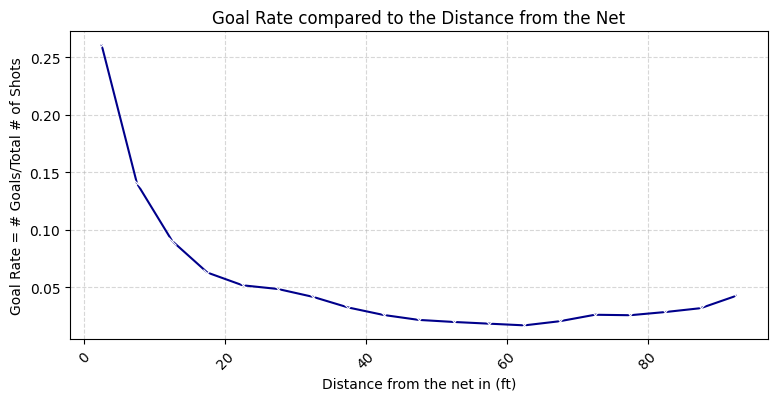

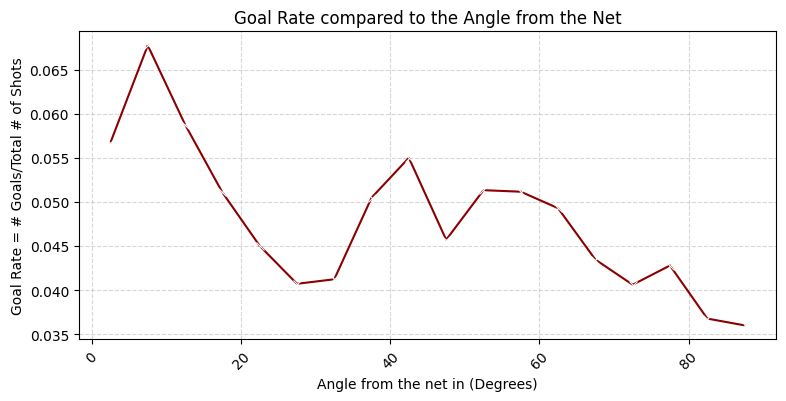

In [4]:
## Defining bins for the histogram to make the plots more interpretable

# 1. Binning the data by distance and then computing the goal rate for distance
# Distance from 0 to 100 in increments of 5
bins_distance = np.arange(0, 100, 5)
dist_goal_rate = (tidy_shots_data.assign(distance_bin=pd.cut(tidy_shots_data['distance_from_net'], bins=bins_distance))
.groupby("distance_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
.assign(goal_rate=lambda df: df['goals'] / df['total'])
.reset_index())

# Convert distance bins to their midpoints for plotting
dist_goal_rate['distance_mid'] = dist_goal_rate['distance_bin'].apply(lambda x: x.mid)

#2. Binning the data by angle and then computing the goal rate for distance
# Distance from 0 to 90 in increments of 5
bins_angle = np.arange(0, 91, 5)
ang_goal_rate = (tidy_shots_data.assign(angle_bin=pd.cut(tidy_shots_data['angle_from_net'], bins=bins_angle))
.groupby("angle_bin").agg(goals=("is_goal", "sum"), total=("is_goal", "count"))
.assign(goal_rate=lambda df: df['goals'] / df['total'])
.reset_index())

# Convert angle bins to midpoints for plotting
ang_goal_rate['angle_mid'] = ang_goal_rate['angle_bin'].apply(lambda x: x.mid)

#3. Plotting the Histogram for Goal Rate vs Distance
plt.figure(figsize=(9,4))
sns.lineplot(data=dist_goal_rate, x='distance_mid', y='goal_rate', marker='x', color='darkblue')
plt.title("Goal Rate compared to the Distance from the Net")
plt.xlabel("Distance from the net in (ft)")
plt.ylabel("Goal Rate = # Goals/Total # of Shots")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#4. Plotting Histogram for Goal Rate vs Angle
plt.figure(figsize=(9,4))
sns.lineplot(data=ang_goal_rate, x='angle_mid', y='goal_rate', marker='x', color='darkred')
plt.title("Goal Rate compared to the Angle from the Net")
plt.xlabel("Angle from the net in (Degrees)")
plt.ylabel("Goal Rate = # Goals/Total # of Shots")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**c) Sanity Check for Goals Empty vs Non-Empty Net**

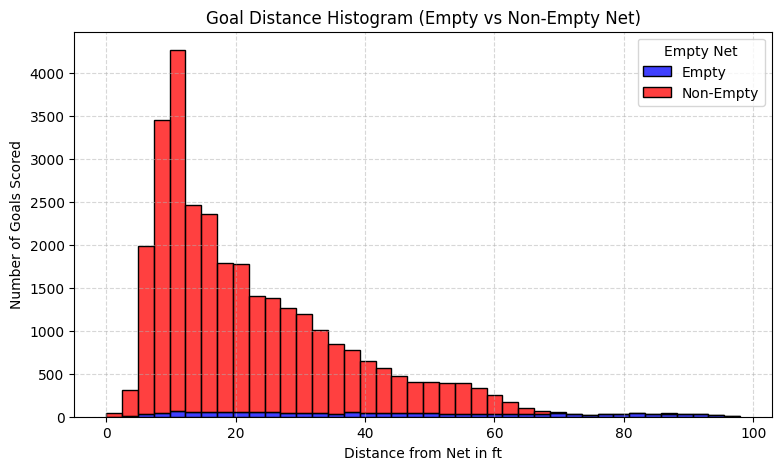

empty_net
0    449050
1    152882
Name: count, dtype: int64

 Possible Anomalous/Outlier Non-Empty Net Goals
No outliers found, all non-empty goals occur within the expected range of (<110 ft).

Distance summary for non-empty goals:
count    29433.000000
mean        21.691347
std         14.032521
min          0.000000
25%         10.630146
50%         17.262677
75%         29.529646
max         95.854056
Name: distance_from_net, dtype: float64

Distance summary for empty-net goals:
count    1492.000000
mean       44.320262
std        25.795589
min         2.000000
25%        21.931712
50%        41.188569
75%        65.789423
max        97.989795
Name: distance_from_net, dtype: float64


In [5]:
# 1. Creating Goals data frame
goals_data = tidy_shots_data[tidy_shots_data["is_goal"]==1].copy()

# 2. Creating bins by distance
# Setting up a larger distance range in order to account for a full rink if necessary
bins_distance = np.arange(0, 200, 5)
goals_data["distance_bin"] = pd.cut(goals_data["distance_from_net"], bins=bins_distance)

# 3. Plotting the histogram separated by an empty net
plt.figure(figsize=(9,5))
sns.histplot(data=goals_data,
             x="distance_from_net",
             hue="empty_net",
             multiple="stack",
             bins=40,
             palette={0: "red", 1: "blue"},)
plt.title("Goal Distance Histogram (Empty vs Non-Empty Net)")
plt.xlabel("Distance from Net in ft")
plt.ylabel("Number of Goals Scored")
plt.legend(title="Empty Net", labels=["Empty", "Non-Empty"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print(tidy_shots_data["empty_net"].value_counts(dropna=False))

## Detecting Anomalies section

# 4. Define distance threshold for anomaly detection
threshold = 110
outliers = goals_data[(goals_data["empty_net"]==0) & (goals_data["distance_from_net"] > threshold)]

print("\n Possible Anomalous/Outlier Non-Empty Net Goals")
if outliers.empty:
    print("No outliers found, all non-empty goals occur within the expected range of (<110 ft).")
else:
    print(f" Found {len(outliers)} potential outliers:")
    display(outliers[["distance_from_net", "angle_from_net", "empty_net"]].head(10))

# (Optional) Summary stats for insight
print("\nDistance summary for non-empty goals:")
print(goals_data[goals_data["empty_net"] == 0]["distance_from_net"].describe())

print("\nDistance summary for empty-net goals:")
print(goals_data[goals_data["empty_net"] == 1]["distance_from_net"].describe())



# **3. Baseline Models**

**a) Logistic Regression and Distance**

In [6]:
## Import train test split, Logistic Regression, and other performance metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import wandb
import joblib

# 1. Dropping NA values from distance and is goal
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "is_goal"])

# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    # notes="commit message for the run",
    name="Basic Logistic Regression Accuracy"
)

# 1. Defining distance as the only feature and is_goal as the target
X = tidy_shots_data[["distance_from_net"]]
y = tidy_shots_data["is_goal"]

# 2. Perform the train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Printing the size of the training and test set
print(f"This is the size of the training set: {X_train.shape[0]}")
print(f"This is this the size of test set: {X_val.shape[0]}")

# 3. Implementing the Logistic Regression Model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 4. Evaluating the model on the validation set
y_predicted = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)

# Log metrics
wandb.log({
    "accuracy": accuracy,
    })

# Create Artifact object
joblib.dump(clf, 'logistic_regression_model.pkl')
model_artifact = wandb.Artifact(name='logistic_regression_model', type='model')
model_artifact.add_file('logistic_regression_model.pkl')
wandb.log_artifact(model_artifact)

# Finish the run
wandb.finish()

# 5. Performance Metrics
print(f"\n The Validation Accuracy is: {accuracy:.4f}")
print("\n The Classification Report is:")
print(classification_report(y_val, y_predicted, target_names=["No Goal", "Goal"]))

print("\n The Confusion Matrix is:")
print(confusion_matrix(y_val, y_predicted))

wandb: Currently logged in as: sina-vali (IFT6758-2025-B08) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


This is the size of the training set: 481529
This is this the size of test set: 120383



 The Validation Accuracy is: 0.9486

 The Classification Report is:
              precision    recall  f1-score   support

     No Goal       0.95      1.00      0.97    114198
        Goal       0.00      0.00      0.00      6185

    accuracy                           0.95    120383
   macro avg       0.47      0.50      0.49    120383
weighted avg       0.90      0.95      0.92    120383


 The Confusion Matrix is:
[[114198      0]
 [  6185      0]]


/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetr

**b) i)  ROC Curve**


The AUC Score is: 0.6817


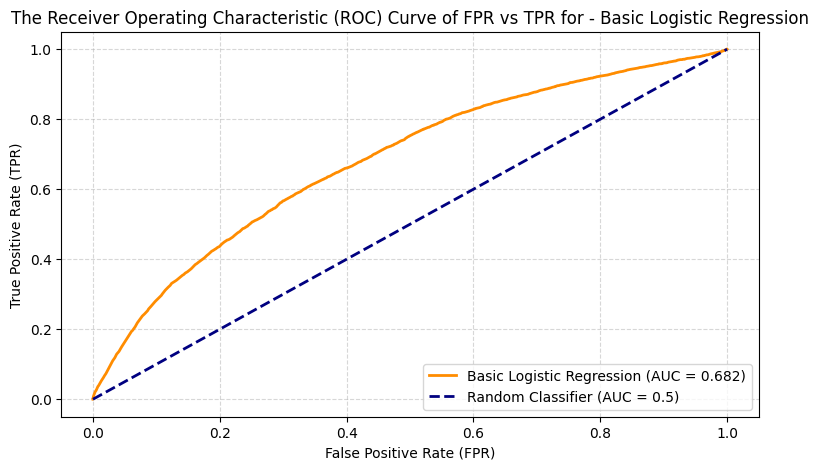

In [7]:
def plot_roc(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} ROC score"
  )

  # 1. Gathering predicted probabilities for the positive class "goal"
  y_probas = clf.predict_proba(X_val)[:,1]

  # 2. Computing the ROC curve
  fpr, tpr, boundaries = roc_curve(y_val, y_probas)

  # 3. Getting auc_score
  auc_score = roc_auc_score(y_val, y_probas)

  # 4. Plotting the ROC curve
  plt.figure(figsize=(9,5))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
  # 5. Setting The title
  plt.title(f"The Receiver Operating Characteristic (ROC) Curve of FPR vs TPR for - {model_name}")
  # 6. Setting the x and y axis label
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  # 7. Plotting the legend
  plt.legend(loc="lower right")
  plt.grid(True, linestyle='--', alpha=0.5)

  # Log the plot as an image to W&B
  wandb.log({f"ROC Curve - {model_name}": wandb.Image(plt)})

  # 9. Printing the AUC score
  print(f"\nThe AUC Score is: {auc_score:.4f}")
  # wandb.log({"AUC Score": auc_score})

  # 8. Plotting the graph
  plt.show()
  wandb.finish()

plot_roc(clf, X_val, y_val, model_name="Basic Logistic Regression")

**b) ii) Goal Rate by Predicted Probability Percentile**

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


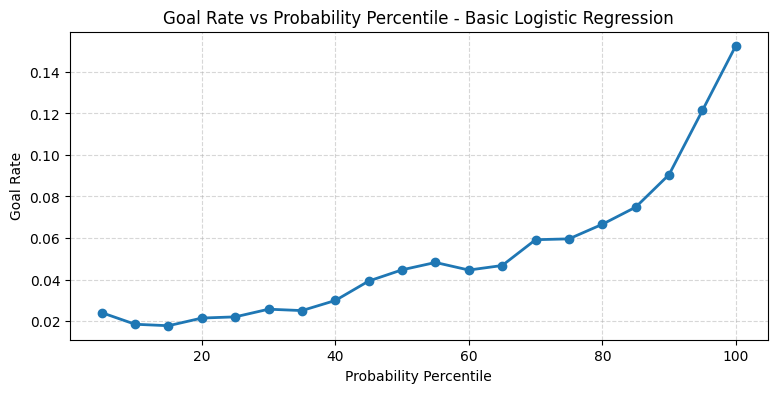

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb

def plot_goal_rate_by_percentile(clf, X_val, y_val, model_name):
    # Initialize W&B run
    run = wandb.init(
        project="IFT6758-Milestone2",
        name=f"{model_name} Goal Rate by Predicted Probability Percentile"
    )

    # 1. Predicted probabilities
    y_probas = clf.predict_proba(X_val)[:, 1]

    # 2. Create evaluation DataFrame
    df_evaluation = pd.DataFrame({
        "y_val": y_val,
        "y_probas": y_probas
    })

    # 3. Compute percentiles (20 bins = every 5th percentile)
    df_evaluation["percentile_bin"] = pd.qcut(df_evaluation["y_probas"], q=20, duplicates="drop")

    # 4. Compute goal rate per bin
    rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()

    # 5. Convert percentile bins into 0–100 percentile ranks
    rate_of_goal["percentile_rank"] = (rate_of_goal.index + 1) * (100 / len(rate_of_goal))

    # 6. Plot line chart
    plt.figure(figsize=(9, 4))
    plt.plot(rate_of_goal["percentile_rank"], rate_of_goal["y_val"], marker='o', linewidth=2)
    plt.title(f"Goal Rate vs Probability Percentile - {model_name}")
    plt.xlabel("Probability Percentile")
    plt.ylabel("Goal Rate")
    plt.grid(True, linestyle='--', alpha=0.5)

    #7 Log to WandB
    wandb.log({f"Goal Rate vs Probability Percentile - {model_name}": wandb.Image(plt)})

    wandb.finish()

    plt.show()

plot_goal_rate_by_percentile(clf, X_val, y_val, model_name="Basic Logistic Regression")



**b) iii) Cumulative Proportion of Goals by Model Probability**

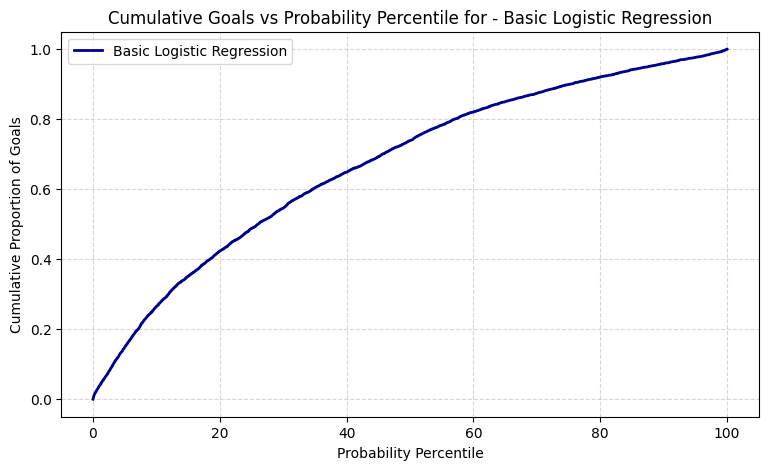

In [9]:
def plot_cum_prop_goals_by_prob(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} Cumulative Proportion of Goals by Model Probability"
  )

  # 0. Compute predicted probabilities for the positive class "goal" and create a DataFrame that can be used for evaluation
  y_probas = clf.predict_proba(X_val)[:,1]

  df_evaluation = pd.DataFrame({
      "y_val": y_val,
      "y_probas": y_probas
  })
  # 1. We will first sort the df_eval by the predicted probability values
  df_eval_sorted = df_evaluation.sort_values("y_probas", ascending=False)
  # 2. Calculating cumulative goals
  df_eval_sorted["cum_goals"] = df_eval_sorted["y_val"].cumsum()
  # 3. Calculating fraction of cumulative goals
  df_eval_sorted["fraction_cum_goals"] = df_eval_sorted["cum_goals"] / df_eval_sorted["y_val"].sum()
  # 4. Calculating fraction of cumulative shots
  df_eval_sorted["fraction_cum_shots"] = np.arange(len(df_eval_sorted)) / len(df_eval_sorted)

  # 5. Plotting cumulative goals vs shots
  plt.figure(figsize=(9,5))
  plt.plot(df_eval_sorted["fraction_cum_shots"], df_eval_sorted["fraction_cum_goals"], color='darkblue', lw=2, label=model_name)
  # 6. Plottin the title, axis, and legend
  plt.title(f"Cumulative Goals vs Probability Percentile for - {model_name}")
  plt.xlabel("Probability Percentile")
  plt.ylabel("Cumulative Proportion of Goals")
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.5)

  # Show x-axis in percentiles (0–100)
  plt.xticks(np.linspace(0, 1, 6), [0, 20, 40, 60, 80, 100])

  # Log the plot as an image to W&B
  wandb.log({f"Cumulative Proportion of Goals by Model Probability - {model_name}": wandb.Image(plt)})

  plt.show()
  wandb.finish()

plot_cum_prop_goals_by_prob(clf, X_val, y_val, model_name="Basic Logistic Regression")

**b) iv) Reliability Diagram (The Calibration Curve)**

<Figure size 900x500 with 0 Axes>

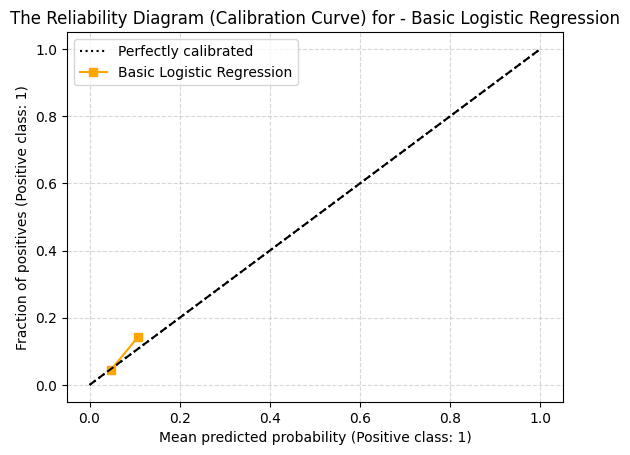

In [10]:
def plot_reliability_diagram(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} Calibration Curve"
  )

  # 1. Plotting figure and Calibration Display for Reliability diagram
  plt.figure(figsize=(9,5))
  CalibrationDisplay.from_estimator(
      clf, X_val, y_val, n_bins=10, name=model_name, color='orange'
  )

  # 2. Plotting the plot, title, grid, and legend
  plt.plot([0, 1], [0, 1], linestyle='--', color='black')
  plt.title(f"The Reliability Diagram (Calibration Curve) for - {model_name}")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend()

  # Log the plot as an image to W&B
  wandb.log({f"Calibration Curve - {model_name}": wandb.Image(plt)})

  plt.show()
  wandb.finish()

plot_reliability_diagram(clf, X_val, y_val, model_name="Basic Logistic Regression")

**c) i) Training the Logistic Regression Model with more Features**

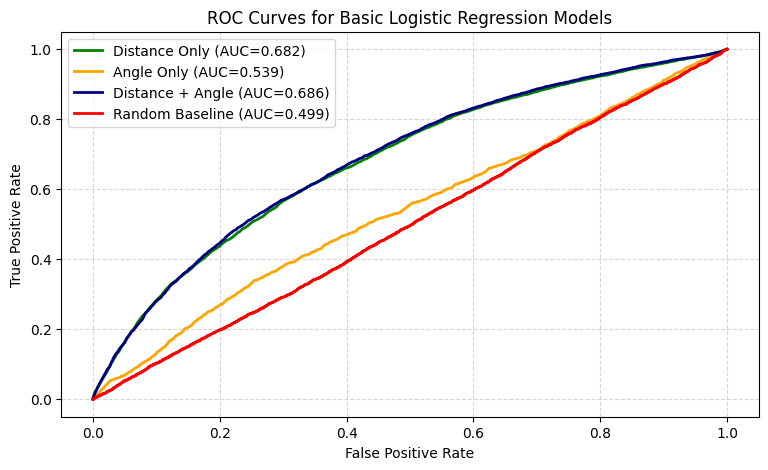

 Saved Logistic Regression models locally


 Uploaded logreg_distance as W&B artifact


 Uploaded logreg_angle as W&B artifact


 Uploaded logreg_distance_angle as W&B artifact

 All three Logistic Regression models uploaded successfully to W&B!


<Figure size 640x480 with 0 Axes>

In [11]:
# Q3 — Logistic Regression Models (Distance / Angle / Distance+Angle)
# 1. W&B Initialization
wandb.login()
project_name = "IFT6758-Milestone2"
entity_name = "luciush1998"

# 2. Data Preparation
# Drop NAs from distance_from_net, angle_from_net, and is_goal
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "angle_from_net", "is_goal"])

# Define feature subsets
X_dist = tidy_shots_data[["distance_from_net"]]
X_ang = tidy_shots_data[["angle_from_net"]]
X_tog = tidy_shots_data[["distance_from_net", "angle_from_net"]]
y = tidy_shots_data["is_goal"]

# Split for each model (same stratified split for consistency)
X_train_d, X_val_d, y_train, y_val = train_test_split(X_dist, y, test_size=0.2, random_state=42, stratify=y)
X_train_ang, X_val_ang, _, _ = train_test_split(X_ang, y, test_size=0.2, random_state=42, stratify=y)
X_train_tog, X_val_tog, _, _ = train_test_split(X_tog, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train Models
clf_dist = LogisticRegression(max_iter=1000).fit(X_train_d, y_train)
clf_ang = LogisticRegression(max_iter=1000).fit(X_train_ang, y_train)
clf_tog = LogisticRegression(max_iter=1000).fit(X_train_tog, y_train)

# 4. Compute Predictions
y_prob_dist = clf_dist.predict_proba(X_val_d)[:, 1]
y_prob_ang = clf_ang.predict_proba(X_val_ang)[:, 1]
y_prob_tog = clf_tog.predict_proba(X_val_tog)[:, 1]
y_prob_rand = np.random.uniform(0, 1, size=len(y_val))

# 5. Log Metrics and Plots to W&B
auc_logs = {}
plt.figure(figsize=(9,5))

for y_prob, label, color in [
    (y_prob_dist, "Distance Only", "green"),
    (y_prob_ang, "Angle Only", "orange"),
    (y_prob_tog, "Distance + Angle", "navy"),
    (y_prob_rand, "Random Baseline", "red"),
]:
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    auc_logs[label] = auc
    plt.plot(fpr, tpr, lw=2, color=color, label=f"{label} (AUC={auc:.3f})")

plt.title("ROC Curves for Basic Logistic Regression Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Log to W&B
wandb.init(project=project_name, name="Q3 - Logistic Regression Baselines", config={"model_type": "logreg"})
wandb.log(auc_logs)
wandb.log({"ROC Curves": wandb.Image(plt)})
wandb.finish()

# 6. Save Models Locally
joblib.dump(clf_dist, "logreg_distance.pkl")
joblib.dump(clf_ang, "logreg_angle.pkl")
joblib.dump(clf_tog, "logreg_distance_angle.pkl")
print(" Saved Logistic Regression models locally")

# 7. Upload Models as W&B Artifacts
for model_name, model_file in [
    ("logreg_distance", "logreg_distance.pkl"),
    ("logreg_angle", "logreg_angle.pkl"),
    ("logreg_distance_angle", "logreg_distance_angle.pkl"),
]:
    run = wandb.init(project=project_name, name=f"Artifact Upload - {model_name}")
    artifact = wandb.Artifact(name=model_name, type="model")
    artifact.add_file(model_file)
    wandb.log_artifact(artifact)
    run.finish()
    print(f" Uploaded {model_name} as W&B artifact")

print("\n All three Logistic Regression models uploaded successfully to W&B!")

**c) ii) Plotting the ROC Curve across the 4 models**

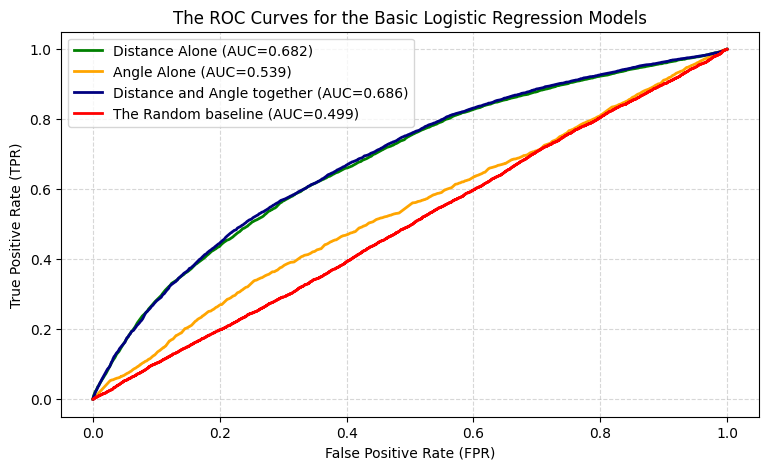

In [12]:
# 1. Plotting the figure together
plt.figure(figsize=(9,5))

# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    # notes="commit message for the run",
    name="Logistic Regression AUC"
)

auc_logs = {}

# 2. Iterating y_prob and label over the various models
for y_prob, label, color in [
    (y_prob_dist,  "Distance Alone", "green"),
    (y_prob_ang, "Angle Alone",    "orange"),
    (y_prob_tog,  "Distance and Angle together", "navy"),
    (y_prob_rand,  "The Random baseline", "red"),
]:
# 3. Computing the false positive and true positive rate (fpr and tpr)
    fpr, tpr, _ = roc_curve(y_val, y_prob)

    # 4. Calculating the area under the curve
    auc = roc_auc_score(y_val, y_prob)
    auc_logs[label] = auc

    # 5. Plotting the false positive rate, true positive rate, etc
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", lw=2, color=color)

# 6. Plotting the title, x and y labels, legend, and grid
plt.title("The ROC Curves for the Basic Logistic Regression Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 7. Log metrics
wandb.log(auc_logs)

# 8 Finish the run
wandb.finish()

**c) iii) Goal Rate sorted by Percentile Plot**

/tmp/ipykernel_169009/605013116.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
/tmp/ipykernel_169009/605013116.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
/tmp/ipykernel_169009/605013116.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rates = prob_df.groupby("percenti

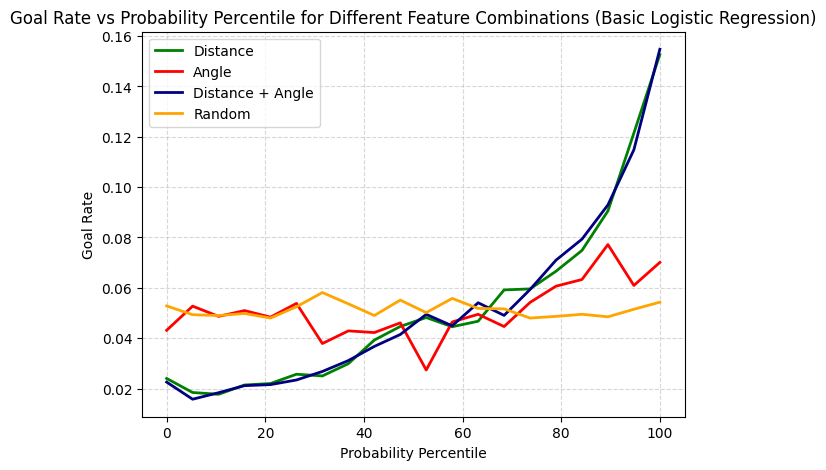

In [13]:
# 1. Defining function for goal rate curve
def gr_curve(y_true, y_prob, label, color):
    prob_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    prob_df["percentile"] = pd.qcut(prob_df["y_prob"], q=20, duplicates="drop")
    goal_rates = prob_df.groupby("percentile")["y_true"].mean().values
    plt.plot(np.linspace(0,100,len(goal_rates)), goal_rates, label=label, color=color, lw=2)
    plt.xticks(range(0, 101, 20))

# 2. Start a new W&B run
run = wandb.init(
    project="IFT6758-Milestone2",
    name="Goal Rate vs Probability Percentile (Logistic Regression Models)"
)

# 3. Plot goal rate curves for all models
plt.figure(figsize=(7, 5))
gr_curve(y_val, y_prob_dist, "Distance", "green")
gr_curve(y_val, y_prob_ang, "Angle", "red")
gr_curve(y_val, y_prob_tog, "Distance + Angle", "navy")
gr_curve(y_val, y_prob_rand, "Random", "orange")

# 4. Configure plot titles, labels, grid, legend
plt.title("Goal Rate vs Probability Percentile for Different Feature Combinations (Basic Logistic Regression)")
plt.xlabel("Probability Percentile")
plt.ylabel("Goal Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 5 Capturing the current figure
fig = plt.gcf()

# 6. Log the figure to W&B
wandb.log({"Goal Rate vs Probability Percentile (Logistic Regression)": wandb.Image(plt)})

# 7. Show plot
plt.show()


# 8. Finish W&B run
wandb.finish()

**c) iv) Defining The Cumulative Goals Curve**

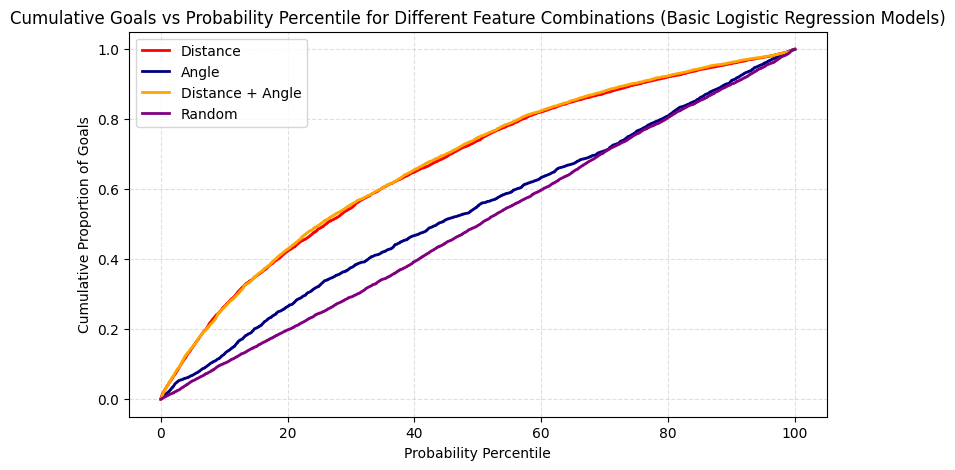

In [14]:
# 1. Defining the cg (cumulative goals function)
def cg(y_true, y_prob, label, color):
    cg_df = pd.DataFrame({"y_true": y_true, "y_prob": y_prob}).sort_values("y_prob", ascending=False)
    cg_df["cum_goals"] = cg_df["y_true"].cumsum() / cg_df["y_true"].sum()
    cg_df["cum_shots"] = np.arange(len(cg_df)) / len(cg_df)
    plt.plot(cg_df["cum_shots"], cg_df["cum_goals"], label=label, color=color, lw=2)

# 2. Initialize W&B run
run = wandb.init(
    project="IFT6758-Milestone2",
    name="Cumulative Goals vs Probability Percentile (Logistic Regression Models)"
)

# 3. Plot cumulative goal curves for the four feature combinations
plt.figure(figsize=(9,5))
cg(y_val, y_prob_dist, "Distance", "red")
cg(y_val, y_prob_ang, "Angle", "navy")
cg(y_val, y_prob_tog, "Distance + Angle", "orange")
cg(y_val, y_prob_rand, "Random", "purple")

# 4. Add titles, labels, grid, and legend
plt.title("Cumulative Goals vs Probability Percentile for Different Feature Combinations (Basic Logistic Regression Models)")
plt.xlabel("Probability Percentile")
plt.ylabel("Cumulative Proportion of Goals")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# X-axis ticks as 0, 20, 40, 60, 80, 100
plt.xticks(np.linspace(0, 1, 6), [0, 20, 40, 60, 80, 100])

# 5 Capturing the current figure
fig = plt.gcf()

# 6. Log the figure to W&B
wandb.log({"Cumulative Goals vs Probability Percentile (Logistic Regression)": wandb.Image(plt)})

# 5. Show the figure
plt.show()

# 7. Finish the W&B run
wandb.finish()

**c) v) Defining The Calibration Curve**

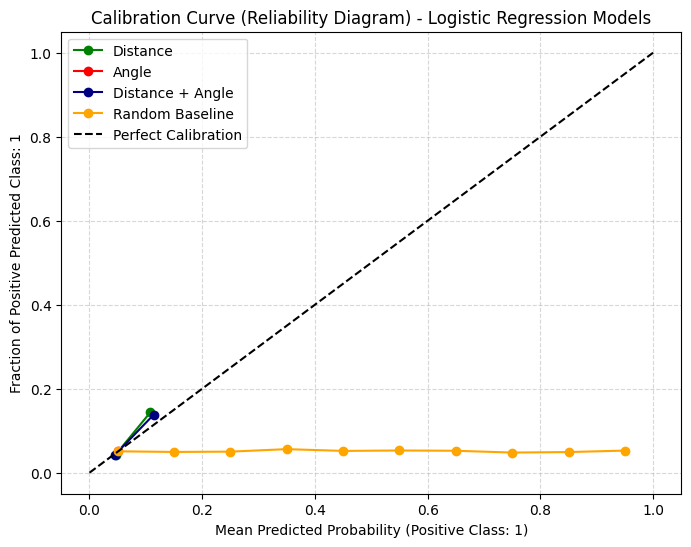

In [15]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# 1. Start W&B run
run = wandb.init(
    project="IFT6758-Milestone2",
    name="Calibration Curve - Logistic Regression (4 Curves)",
    config={
        "model_type": "Logistic Regression",
        "curves": ["Distance", "Angle", "Distance+Angle", "Random"],
        "n_bins": 10
    }
)

# 2. Compute calibration curves manually for better control ---
prob_true_dist, prob_pred_dist = calibration_curve(y_val, y_prob_dist, n_bins=10)
prob_true_ang, prob_pred_ang = calibration_curve(y_val, y_prob_ang, n_bins=10)
prob_true_tog, prob_pred_tog = calibration_curve(y_val, y_prob_tog, n_bins=10)
prob_true_rand, prob_pred_rand = calibration_curve(y_val, y_prob_rand, n_bins=10)

# 3. Create a single figure with 4 curves ---
plt.figure(figsize=(8, 6))

# 4. Distance model
plt.plot(prob_pred_dist, prob_true_dist, marker="o", color="green", label="Distance")

# 5. Angle model
plt.plot(prob_pred_ang, prob_true_ang, marker="o", color="red", label="Angle")

# 6. Distance + Angle model
plt.plot(prob_pred_tog, prob_true_tog, marker="o", color="navy", label="Distance + Angle")

# 7. Random baseline
plt.plot(prob_pred_rand, prob_true_rand, marker="o", color="orange", label="Random Baseline")

# 8. Perfect Calibration Curve
plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Perfect Calibration")

# 9. Add title, labels, legend, and grid
plt.title("Calibration Curve (Reliability Diagram) - Logistic Regression Models")
plt.xlabel("Mean Predicted Probability (Positive Class: 1)")
plt.ylabel("Fraction of Positive Predicted Class: 1")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# 10. --- Log to W&B ---
wandb.log({
    "Calibration Curve - Logistic Regression (4 Curves)": wandb.Image(plt),
    "Brier Score (Distance)": brier_score_loss(y_val, y_prob_dist),
    "Brier Score (Angle)": brier_score_loss(y_val, y_prob_ang),
    "Brier Score (Distance + Angle)": brier_score_loss(y_val, y_prob_tog),
    "Brier Score (Random)": brier_score_loss(y_val, y_prob_rand)
})

plt.show()
wandb.finish()


# **4. Feature Engineering II**

**a) Adding new Features**

In [16]:
# 1. Start from your initial shots_df data set
df_shots = shots_df.copy()

# 2. Creating the Game Seconds column by breaking down and recombining the timeInPeriod column
# Specifically we convert time string "MM:SS" to total seconds
df_shots["game_seconds"] = df_shots["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)

# 3. We can use existing columns and rename them to game period along with the x and y coordinates, also adding in game_id and game_seconds
df_shots["game_id"] = df_shots["id"]
df_shots["game_period"] = df_shots["periodDescriptor_number"]
df_shots["x_coord"] = df_shots["x_standardized"]
df_shots["y_coord"] = df_shots["y_standardized"]

# 4. Renaming columns to obtain shot distance, shot angle, and shot type
df_shots.rename(columns={
    "distance_from_net": "shot_distance",
    "angle_from_net": "shot_angle",
    "typeDescKey": "shot_type"
}, inplace=True)

# 5. Selecting final tidy dataset with all the required columns
tidy_data_updated = df_shots[["game_id",
    "game_seconds",
    "game_period",
    "x_coord", "y_coord",
    "shot_distance", "shot_angle",
    "shot_type",
    "is_goal", "empty_net", "season"
]].copy()

# 6. Quick inspection
print(tidy_data_updated.head())
print(tidy_data_updated.columns)



      game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
5  2016020001            63            1     43.0    -23.0      51.429563   
6  2016020001            70            1     61.0    -11.0      30.083218   
7  2016020001            71            1     77.0     -5.0      13.000000   
8  2016020001           125            1     56.0     -2.0      33.060551   
9  2016020001           134            1     52.0      9.0      38.078866   

   shot_angle     shot_type  is_goal  empty_net    season  
5   26.565051  blocked-shot        0          1  20162017  
6   21.447736  blocked-shot        0          1  20162017  
7   22.619865  shot-on-goal        0          0  20162017  
8    3.468229  blocked-shot        0          1  20162017  
9   13.671307   missed-shot        0          0  20162017  
Index(['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord',
       'shot_distance', 'shot_angle', 'shot_type', 'is_goal', 'empty_net',
       'season'],
      dtype='

**b) Adding Events to Shots**

In [17]:
## Adding in Event related columns/features

# 1. Working with all events not exclusively shots
# 2. Making sure 'all_games_df' including every event with coordinates, time, and identifiers

all_games_df["game_id"] = all_games_df["id"]

events_df = all_games_df.copy().sort_values(by=["game_id", "eventId"]).reset_index(drop=True)

# 3. Computing the total game seconds (this would include the period time and the period offset time)
events_df["seconds_of_period"] = events_df["timeInPeriod"].apply(
    lambda t: int(t.split(":")[0]) * 60 + int(t.split(":")[1]) if isinstance(t, str) else np.nan
)
events_df["game_seconds"] = (events_df["periodDescriptor_number"] - 1) * 1200 + events_df["seconds_of_period"]

# 4. Obtain the immediately preceding event information for every NHL game
events_df["last_event_type"] = events_df.groupby("game_id")["typeDescKey"].shift(1)
events_df["last_event_x_coord"] = events_df.groupby("game_id")["details_xCoord"].shift(1)
events_df["last_event_y_coord"] = events_df.groupby("game_id")["details_yCoord"].shift(1)
events_df["last_event_time"] = events_df.groupby("game_id")["game_seconds"].shift(1)

# 5. Computing time since the last event
events_df["time_since_last_event"] = events_df["game_seconds"] - events_df["last_event_time"]
events_df["distance_from_last_event"] = np.sqrt(
    (events_df["details_xCoord"] - events_df["last_event_x_coord"])**2 +
    (events_df["details_yCoord"] - events_df["last_event_y_coord"])**2
)

# 6. Filtering events_df to only shot-related events, note this mirrors shots_df_updated
shots_with_prev = events_df[events_df["typeDescKey"].isin(["shot-on-goal", "goal"])].copy()

# 7. Keep only columns you need for merging
shots_with_prev_events = shots_with_prev[[
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]]

# 8. Defining the columns that will be merged on
merge_cols = [
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]

# 9. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in merge_cols if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 10. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated = tidy_data_updated.merge(
    shots_with_prev[merge_cols],
    on=["game_id", "game_seconds"],
    how="left"
)

# 11. Confirming the merge worked and previewing the data
print("\n The Merge has completed safely with 0 redundant columns created.")
print(f" The tidy_data_updated now has these many: {len(tidy_data_updated.columns)} columns.")
print(list(tidy_data_updated.columns))
print("\n This is a preview of the new tidy update columns table: ")
print(tidy_data_updated.head())



 The Merge has completed safely with 0 redundant columns created.
 The tidy_data_updated now has these many: 16 columns.
['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord', 'shot_distance', 'shot_angle', 'shot_type', 'is_goal', 'empty_net', 'season', 'last_event_type', 'last_event_x_coord', 'last_event_y_coord', 'time_since_last_event', 'distance_from_last_event']

 This is a preview of the new tidy update columns table: 
      game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
0  2016020001            63            1     43.0    -23.0      51.429563   
1  2016020001            70            1     61.0    -11.0      30.083218   
2  2016020001            71            1     77.0     -5.0      13.000000   
3  2016020001           125            1     56.0     -2.0      33.060551   
4  2016020001           134            1     52.0      9.0      38.078866   

   shot_angle     shot_type  is_goal  empty_net    season last_event_type  \
0   26.565051  block

**c) Adding in Rebound, Change in shot angle, and speed**

In [18]:
# Adding additional features including: Rebound, Change in Angle, and the Speed columns

# 1. Creating data frame of shots only feature including goals or shot-on-goal
shots_only_features = tidy_data_updated.copy()

# 2. Creating the rebound column which is true if the most recent event was a shot
shots_only_features["rebound"] = shots_only_features["last_event_type"].isin(["shot-on-goal", "goal"])

# 3. Creating the Shot Angle colum whereh shot is a rebound and otherwise set to 0
# Convert from radians to degrees
shots_only_features["change_in_shot_angle"] = np.where(
    shots_only_features["rebound"],
    np.abs(shots_only_features["shot_angle"] - np.arctan2(
        shots_only_features["y_coord"] - shots_only_features["last_event_y_coord"],
        shots_only_features["x_coord"] - shots_only_features["last_event_x_coord"]
    ) * 180 / np.pi),
    0
)

# 4. Creating the speed column divided with the formula distance from previous event/time from previous event)
# Consider possible divide by zero case
shots_only_features["speed"] = np.where(
    (shots_only_features["time_since_last_event"] > 0) & (~shots_only_features["time_since_last_event"].isna()),
    shots_only_features["distance_from_last_event"] / shots_only_features["time_since_last_event"],
    np.nan
)

# 5. Clean up extreme values (optional but good practice)
shots_only_features.loc[shots_only_features["speed"] > 1000, "speed"] = np.nan

# 6. View the resulting columns to make sure everything is added properly
print("\n Adding new columns to tidy_data including: rebound, change_in_shot_angle, and speed")
print(shots_only_features[[
    "game_id", "game_seconds", "shot_type",
    "last_event_type", "rebound", "change_in_shot_angle", "speed"
]].head(10))

# 7. Updating your main tidy dataset and make sure everything is correct
tidy_data_updated = shots_only_features

# 8. Previewing updated data set
print("\n These are the new columns of tidy_data_updated")
print(tidy_data_updated.head())

# 9. Seeing new columns created
print("\n These are the new columns of tidy_data_updated")
print(tidy_data_updated.columns)



 Adding new columns to tidy_data including: rebound, change_in_shot_angle, and speed
      game_id  game_seconds     shot_type last_event_type  rebound  \
0  2016020001            63  blocked-shot             NaN    False   
1  2016020001            70  blocked-shot             NaN    False   
2  2016020001            71  shot-on-goal         faceoff    False   
3  2016020001           125  blocked-shot             NaN    False   
4  2016020001           134   missed-shot             NaN    False   
5  2016020001           139  blocked-shot             NaN    False   
6  2016020001           173  shot-on-goal             hit    False   
7  2016020001           216  blocked-shot             NaN    False   
8  2016020001           223   missed-shot             NaN    False   
9  2016020001           241  shot-on-goal         faceoff    False   

   change_in_shot_angle      speed  
0                   0.0        NaN  
1                   0.0        NaN  
2                   0.0   2.2288

**d) Bonus Section (Power Play Analysis)**

In [19]:
# 1. Analyze situation code to obtain Power Play Details (
power_play_df = all_games_df.copy()
power_play_df["game_id"] = power_play_df["id"]

# 2. Clean up situationCode safely before using extract_skaters
power_play_df["situationCode"] = (
    power_play_df["situationCode"]
    .astype(str)                       # convert everything to string
    .str.strip()                       # remove spaces around
    .str.replace(r"\.0$", "", regex=True)  # drop trailing .0 from floats
    .replace(["None", "nan", "NaN", "NULL", "NoneType"], np.nan)  # handle text NaNs
)

# 3. Keep only rows with purely numeric 3- or 4-digit codes
mask = power_play_df["situationCode"].str.match(r"^\d{3,4}$", na=False)
power_play_df = power_play_df[mask].copy()

# 4. Apply Extract Skaters column
def extract_skaters(code):
    code = str(int(code))
    if len(code) == 4:
        return int(code[1]), int(code[2])
    elif len(code) == 3:
        return int(code[0]), int(code[1])
    else:
        return np.nan, np.nan

pairs = [extract_skaters(c) for c in power_play_df["situationCode"]]
if pairs:
    home, away = zip(*pairs)
else:
    home, away = ([], [])

# 5. Define Home and Away skaters
power_play_df["home_skaters"] = home if len(home) else np.nan
power_play_df["away_skaters"] = away if len(away) else np.nan


# 6. Computing whether a power play is actually happening
invalid_codes = ["101", "560", "660"]
power_play_df["valid_power_play"] = (
    (power_play_df["home_skaters"] != power_play_df["away_skaters"]) &
    (~power_play_df["situationCode"].astype(str).isin(invalid_codes))
)

# 7. Now we identify which team is on the power play
power_play_df["power_play_team"] = np.where(
    power_play_df["home_skaters"] > power_play_df["away_skaters"], "home",
    np.where(power_play_df["away_skaters"] > power_play_df["home_skaters"], "away", None)
)

# 8. Computing the total game seconds, similar to the methods employed before (This is where we convert MM:SS to total seconds + add period offset)
power_play_df["seconds_in_period"] = power_play_df["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)
power_play_df["game_seconds"] = (
    (power_play_df["periodDescriptor_number"] - 1) * 1200 + power_play_df["seconds_in_period"]
)

# 9. Sorting chronologically within each game in order to make the data set easier to read
power_play_df = power_play_df.sort_values(by=["id", "game_seconds"]).reset_index(drop=True)

# 10. Calculating the "time since power play started"
# Initially set it to 0
power_play_df["time_since_power_play_start"] = 0.0

# 11. Iterating through id and game events
for game_id, game_events in power_play_df.groupby("id"):
    last_pp_start_time = None
    times = []
    for _, r in game_events.iterrows():
        if r["valid_power_play"]:
            # 9. We first start the power play if power play is not already active
            if last_pp_start_time is None:
                last_pp_start_time = r["game_seconds"]
            times.append(r["game_seconds"] - last_pp_start_time)
        else:
            # 10. We reset timer when player returns to even strength
            last_pp_start_time = None
            times.append(0)
    power_play_df.loc[game_events.index, "time_since_power_play_start"] = times

# 12. Assigning the friendly and opposition's non-goalie skater counts in relation to each event's team
power_play_df["friendly_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["home_skaters"],
    power_play_df["away_skaters"]
)
power_play_df["opposing_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["away_skaters"],
    power_play_df["home_skaters"]
)

# 13. We select only the power play features for power_play_df we will use for merging
power_play_features = power_play_df[[
    "game_id",
    "game_seconds",
    "time_since_power_play_start",
    "friendly_skaters",
    "opposing_skaters"
]].drop_duplicates(subset=["game_id", "game_seconds"])


# 14. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in power_play_features if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 15. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated = tidy_data_updated.merge(
    power_play_features,
    on=["game_id", "game_seconds"],
    how="left"
)

# 16. Removing the redundant 'id' column created during merge (if it exists) as it is irrelevant to the tidy data set as it has the game_id column
if "id" in tidy_data_updated.columns:
    tidy_data_updated.drop(columns=["id"], inplace=True)

# 17. Previewing the final tidy data frame with head
print("\n The Final tidy_data_updated after we combine the Power Play features is:")
print(tidy_data_updated.head())

# 18. Previewing the columns of tidy data updated
print("\n The Columns within the tidy_data_updated data now include:")
print(list(tidy_data_updated.columns))



 The Final tidy_data_updated after we combine the Power Play features is:
      game_id  game_seconds  game_period  x_coord  y_coord  shot_distance  \
0  2016020001            63            1     43.0    -23.0      51.429563   
1  2016020001            70            1     61.0    -11.0      30.083218   
2  2016020001            71            1     77.0     -5.0      13.000000   
3  2016020001           125            1     56.0     -2.0      33.060551   
4  2016020001           134            1     52.0      9.0      38.078866   

   shot_angle     shot_type  is_goal  empty_net  ...  last_event_x_coord  \
0   26.565051  blocked-shot        0          1  ...                 NaN   
1   21.447736  blocked-shot        0          1  ...                 NaN   
2   22.619865  shot-on-goal        0          0  ...                69.0   
3    3.468229  blocked-shot        0          1  ...                 NaN   
4   13.671307   missed-shot        0          0  ...                 NaN   

  las

In [20]:
# Sanity check on friendly and opposing skaters
print("These are the value counts for friendly skater:\n", tidy_data_updated["friendly_skaters"].value_counts())
print("\nThese are the value counts for opposing skater:\n", tidy_data_updated["opposing_skaters"].value_counts())

These are the value counts for friendly skater:
 friendly_skaters
5.0    195518
4.0     30528
3.0       898
6.0       116
0.0         6
1.0         2
Name: count, dtype: int64

These are the value counts for opposing skater:
 opposing_skaters
5.0    218936
4.0      7233
6.0       808
3.0        83
1.0         6
0.0         2
Name: count, dtype: int64


**e) Uploading the final dataframe with wandb**

In [21]:
df = tidy_data_updated.loc[tidy_data_updated["game_id"] == 2017021065]

run = wandb.init(project="my_project")
# create a wandb Artifact for each meaningful step
artifact = wandb.Artifact(
    name="wpg_v_wsh_2017021065",
    type="dataset"
)
# add data
my_table = wandb.Table(dataframe=df)
artifact.add(my_table, "wpg_v_wsh_2017021065")
run.log_artifact(artifact)
run.finish()

In [22]:
# Sampling 10% of the dataframe to be able to run the next sections
tidy_data_updated, _ = train_test_split(
    tidy_data_updated,
    test_size=0.9,            
    stratify=tidy_data_updated["is_goal"],
    random_state=42
)

In [23]:
tidy_data_updated.shape

(60304, 22)

# **5. Advanced Models**

**Part 1 - Training the XGBoost Classifier Using Only the "distance" and "angle" Features**

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:48:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



The AUC Score is: 0.6644


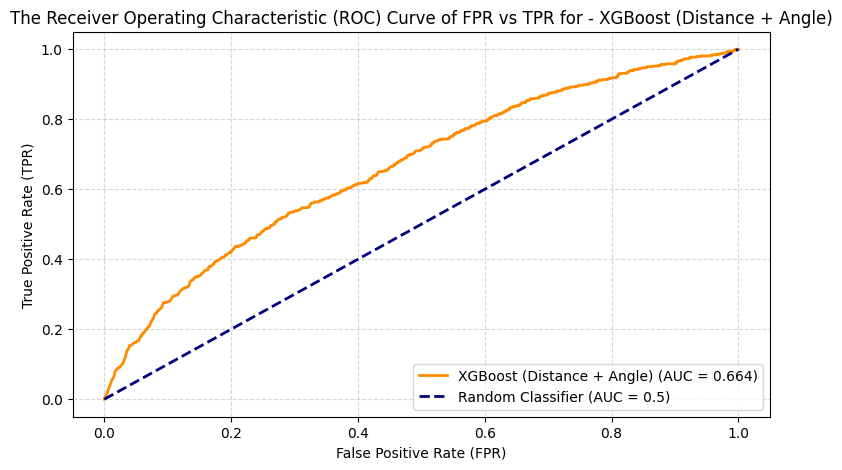

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


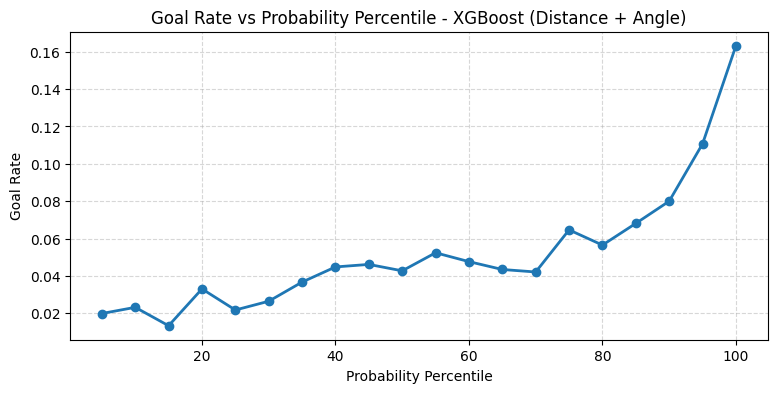

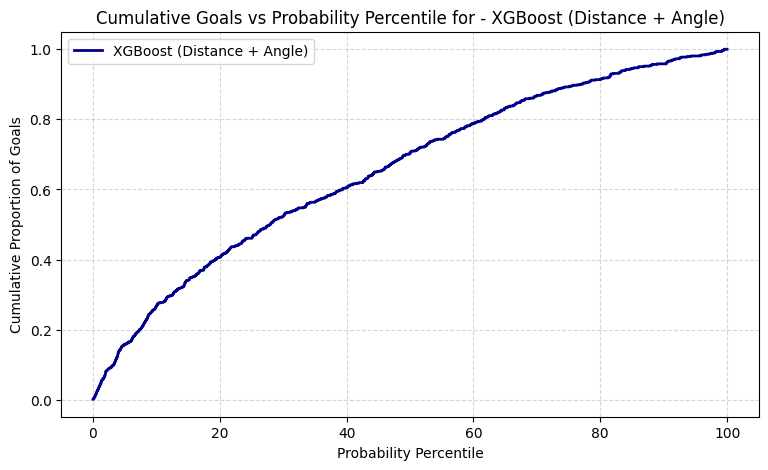

<Figure size 900x500 with 0 Axes>

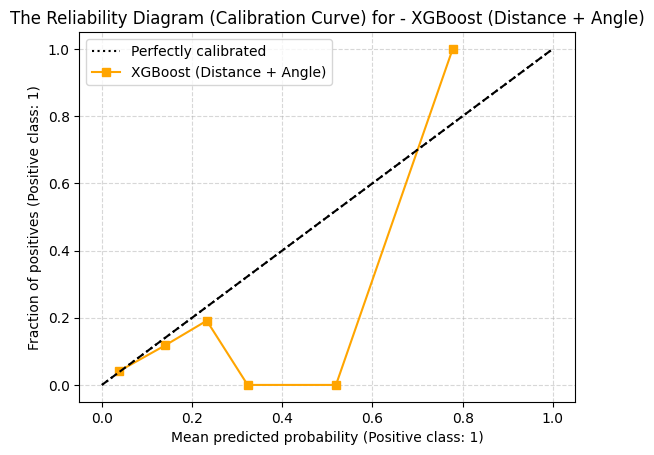

In [24]:
# --- 1. Subset the dataset for XGB baseline ---
features = ["shot_distance", "shot_angle"]
X = tidy_data_updated[features]
y = tidy_data_updated["is_goal"]

# --- 2. Split into train/validation sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Train basic XGBoost model ---
xgb_basic = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb_basic.fit(X_train, y_train)

# --- 4. Log model and plots to W&B ---
model_name = "XGBoost (Distance + Angle)"
plot_roc(xgb_basic, X_val, y_val, model_name)
plot_goal_rate_by_percentile(xgb_basic, X_val, y_val, model_name)
plot_cum_prop_goals_by_prob(xgb_basic, X_val, y_val, model_name)
plot_reliability_diagram(xgb_basic, X_val, y_val, model_name)

**Part 2 - Training the XGBoost Classifier Using All Features with Hyperparameter Tuning**

In [25]:
### Preprocessing
def handle_missing_values(df_input):
    df = df_input.copy()

    # Dropping redundant columns
    df.drop(columns=["game_id", "shot_type"], inplace=True)

    print(f"Missing values before handling: {df.isna().sum().sum()}")
    # Columns with few missing values: remove them
    cols_remove = [col for col in df.columns if df[col].isna().sum() <= 20]
    df.dropna(subset=cols_remove, inplace=True)

    # Categorical column 'last_event_type': fill with 'unknown'
    df['last_event_type'] = df['last_event_type'].fillna('unknown')

    # Numerical columns with many missing values (indicating absence): fill with 0
    numerical_cols_zero = [col for col in df.columns if df[col].isna().sum() > 20]
    for col in numerical_cols_zero:
        df[col] = df[col].fillna(0)

    print(f"Missing values after handling: {df.isna().sum().sum()}")
    return df

# Apply the function to your DataFrame
df = handle_missing_values(tidy_data_updated)

# Apply one-hot encoding to 'shot_type' and 'last_event_type'
df = pd.get_dummies(df, columns=['last_event_type'], drop_first=True)

X = df.drop(columns=['is_goal'])
y = df['is_goal']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Missing values before handling: 408583
Missing values after handling: 0


In [26]:
# Hyperparameter tuning 
run = wandb.init(
    project="IFT6758-Milestone2",
    name="XGBoost trained on all features"
)

artifact = wandb.Artifact(
    name="XGB-Models",
    type="model"
)

xgb = XGBClassifier(
    tree_method="hist",
    random_state=42
)

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [1, 3, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "eval_metric": ["logloss", "auc"]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print("XGB best params:", grid_xgb.best_params_)
print("XGB best CV AUC:", grid_xgb.best_score_)

# Selecting the best model
best_xgb = grid_xgb.best_estimator_

# Save the best model
joblib.dump(best_xgb, "best_xgb_model.pkl")

# Logging the model
artifact.add_file("best_xgb_model.pkl")
run.log_artifact(artifact)
run.finish()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGB best params: {'eval_metric': 'logloss', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
XGB best CV AUC: 0.8214590354826432


**Part 3 - Training XGB with Feature Selection**

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations t

Optimal number of features: 21


/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


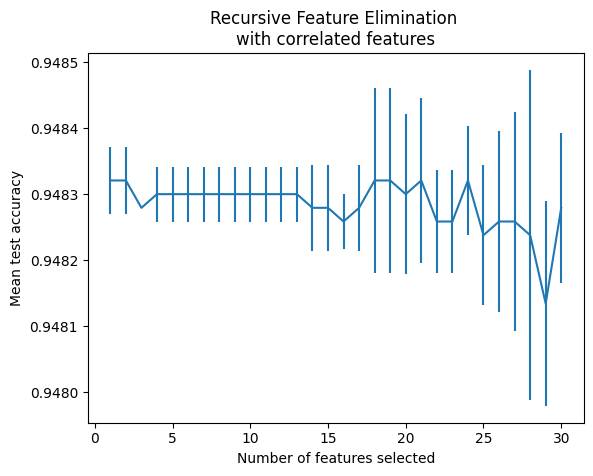

Features selected in fold 0: ['game_period' 'x_coord' 'shot_distance' 'shot_angle' 'empty_net'
 'rebound' 'speed' 'friendly_skaters' 'opposing_skaters'
 'last_event_type_delayed-penalty' 'last_event_type_faceoff'
 'last_event_type_giveaway' 'last_event_type_goal' 'last_event_type_hit'
 'last_event_type_missed-shot' 'last_event_type_penalty'
 'last_event_type_period-end' 'last_event_type_shot-on-goal'
 'last_event_type_stoppage' 'last_event_type_takeaway'
 'last_event_type_unknown']
Features selected in fold 1: ['game_period' 'x_coord' 'shot_distance' 'shot_angle' 'empty_net'
 'rebound' 'speed' 'friendly_skaters' 'opposing_skaters'
 'last_event_type_delayed-penalty' 'last_event_type_faceoff'
 'last_event_type_giveaway' 'last_event_type_goal' 'last_event_type_hit'
 'last_event_type_missed-shot' 'last_event_type_penalty'
 'last_event_type_period-end' 'last_event_type_shot-on-goal'
 'last_event_type_stoppage' 'last_event_type_takeaway'
 'last_event_type_unknown']
Features selected in fold 

In [27]:
### Recursive feature elimination with cross-validation
# Model training and selection
cv = StratifiedKFold(5)
clf = LogisticRegression()

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features VS. cross-validation scores
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

# Select the top features
feature_names = X_train.columns
for i in range(cv.n_splits):
    mask = rfecv.cv_results_[f"split{i}_support"][
        rfecv.n_features_ - 1
    ]  # mask of features selected by the RFE
    features_selected = np.ma.compressed(np.ma.masked_array(feature_names, mask=1 - mask))
    print(f"Features selected in fold {i}: {features_selected}")

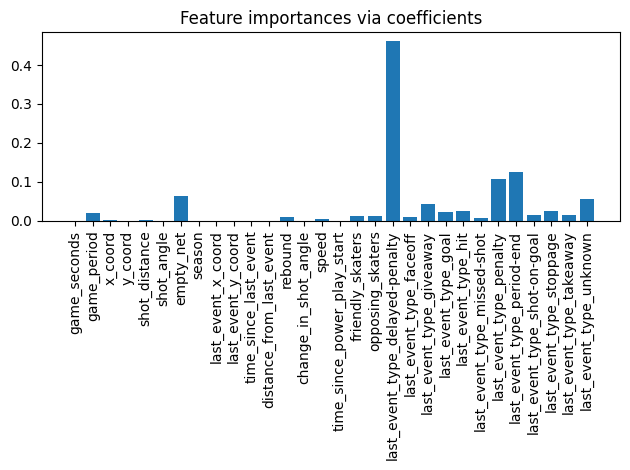

Features selected by SelectFromModel: Index(['last_event_type_delayed-penalty', 'last_event_type_period-end'], dtype='object')


In [28]:
### Model-based and sequential feature selection
# Feature importance from coefficients
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
# feature_names = np.array(X_train.columns)
plt.bar(height=importance, x=feature_names)
plt.xticks(rotation=90)
plt.title("Feature importances via coefficients")
plt.tight_layout() 
plt.show()

# Selecting features based on importance
threshold = np.sort(importance)[-3] + 0.01

sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train, y_train)
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

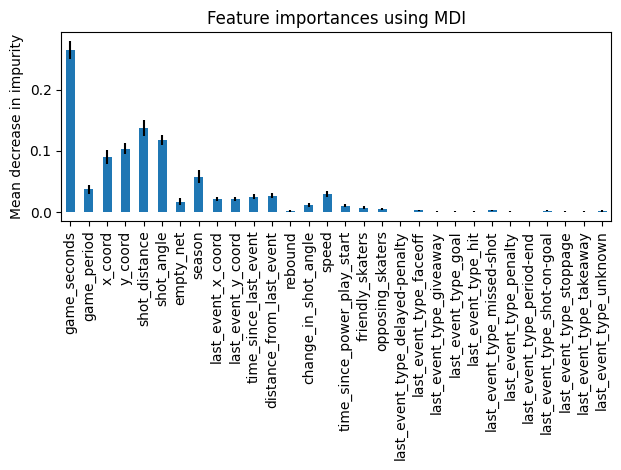

In [29]:
### Feature importances with a forest of trees
# feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

# Feature importance based on mean decrease in impurity
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Plotting the impurity-based importance
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

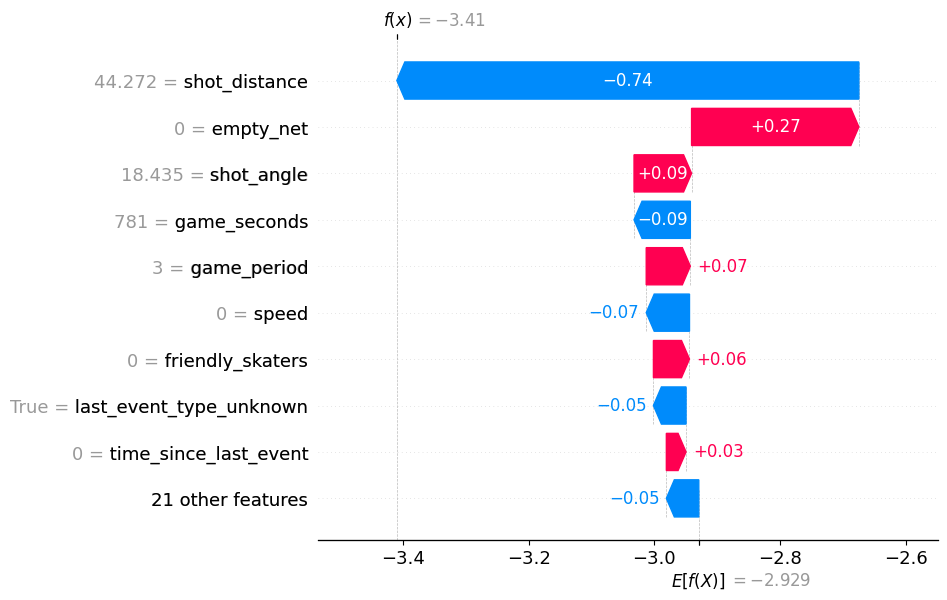

In [30]:
### SHAP
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGB best params: {'eval_metric': 'logloss', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
XGB best CV AUC: 0.8208715517559313



The AUC Score is: 0.8114


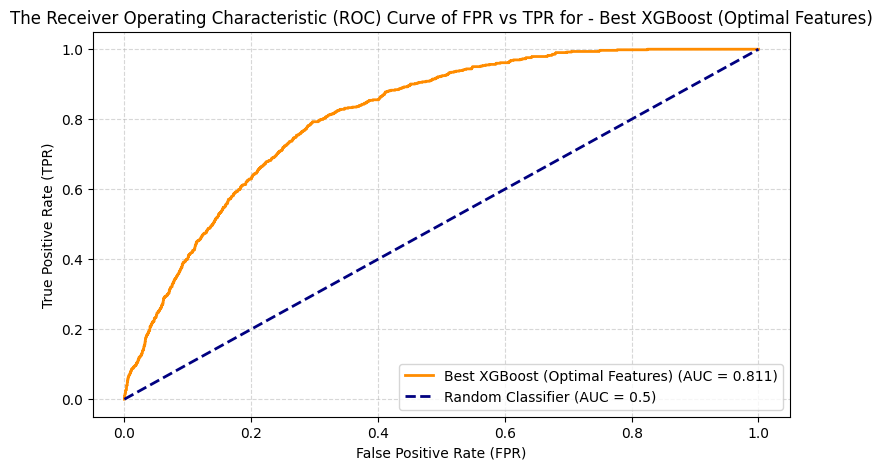

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


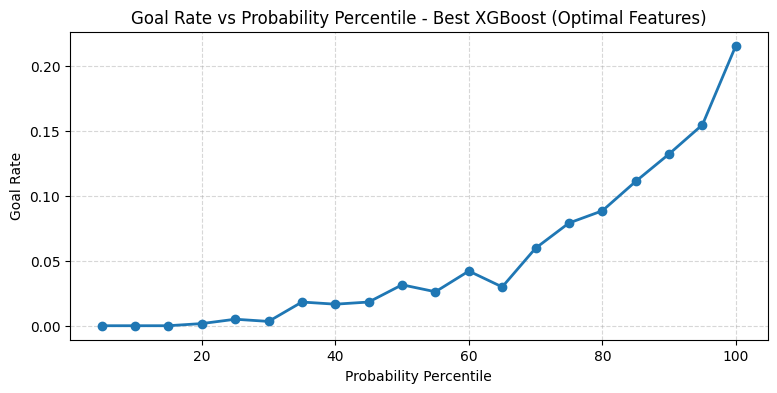

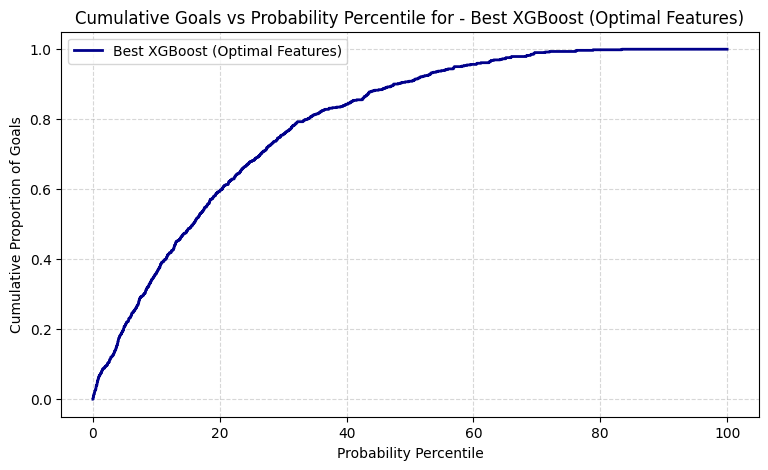

<Figure size 900x500 with 0 Axes>

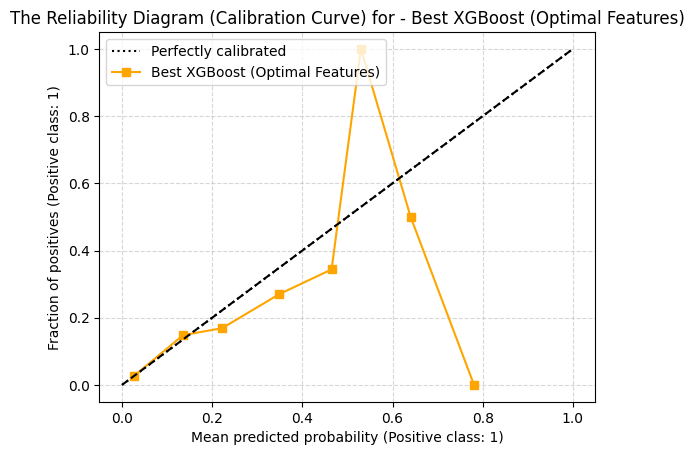

In [31]:
optimal_features = ["empty_net", "shot_distance", "shot_angle", "x_coord", "y_coord", 
                    "game_period", "game_seconds", "last_event_type_unknown", 
                    "friendly_skaters", "opposing_skaters"]

run = wandb.init(
    project="IFT6758-Milestone2",
    name="XGBoost trained on optimal features"
)

artifact = wandb.Artifact(
    name="XGB-Models",
    type="model"
)

# Hyperparameter tuning 
xgb = XGBClassifier(
    tree_method="hist",
    random_state=42
)

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [1, 3, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "eval_metric": ["logloss", "auc"]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train[optimal_features], y_train)
print("XGB best params:", grid_xgb.best_params_)
print("XGB best CV AUC:", grid_xgb.best_score_)

# Selecting the best model
best_xgb = grid_xgb.best_estimator_

# Save the best model
joblib.dump(best_xgb, "best_xgb_model_with_feature_selection.pkl")

# Logging the model
artifact.add_file("best_xgb_model_with_feature_selection.pkl")
run.log_artifact(artifact)
run.finish()

# Log model and plots to W&B
model_name = "Best XGBoost (Optimal Features)"
plot_roc(best_xgb, X_valid[optimal_features], y_valid, model_name)
plot_goal_rate_by_percentile(best_xgb, X_valid[optimal_features], y_valid, model_name)
plot_cum_prop_goals_by_prob(best_xgb, X_valid[optimal_features], y_valid, model_name)
plot_reliability_diagram(best_xgb, X_valid[optimal_features], y_valid, model_name)

# **6. Give it your best shot!**

In [32]:
### Preprocessing
# Standardizing the dataset
X_train, X_valid = X_train[optimal_features], X_valid[optimal_features]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Apply PCA
# pca = PCA(n_components=0.95)
# X_train = pca.fit_transform(X_train)
# X_valid = pca.transform(X_valid)

# Oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Testing different models

### Logistic regression with regularization

In [33]:
logreg = LogisticRegression(max_iter=1000, random_state=42)

param_grid_lr = {
    "C": [0.01, 0.1, 1],
    "penalty": ["l2"],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs", "newton-cholesky"],
}

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_lr,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_train, y_train)

print("Best params:", grid_logreg.best_params_)
print("Best CV AUC:", grid_logreg.best_score_)

best_logreg = grid_logreg.best_estimator_

# Save the best model
# joblib.dump(best_logreg, "best_logreg_model.pkl")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Best CV AUC: 0.7893106027683355


**Quantitative Metrics**

In [34]:
y_pred = best_logreg.predict(X_valid)
report = classification_report(y_valid, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

precision    recall  f1-score       support
0              0.980297  0.687331  0.808080  11437.000000
1              0.115071  0.746388  0.199400    623.000000
accuracy       0.690381  0.690381  0.690381      0.690381
macro avg      0.547684  0.716860  0.503740  12060.000000
weighted avg   0.935601  0.690381  0.776636  12060.000000

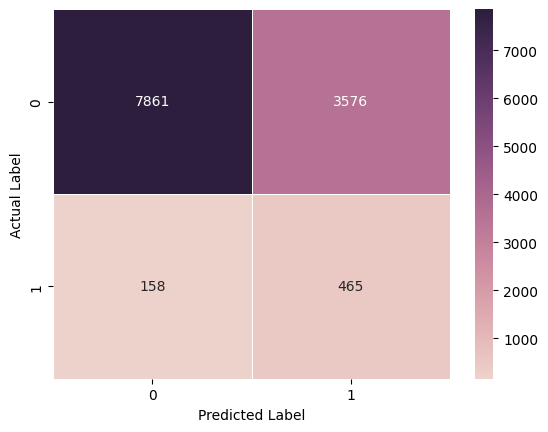

In [35]:
# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    name=f"Logistic Regression Confusion Matrix"
)

cf_matrix=confusion_matrix(y_valid, y_pred)
sns.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True),linewidth=.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
wandb.log({"Logistic Regression Confusion Matrix": wandb.Image(plt)})
plt.show()

wandb.finish()


The AUC Score is: 0.7736


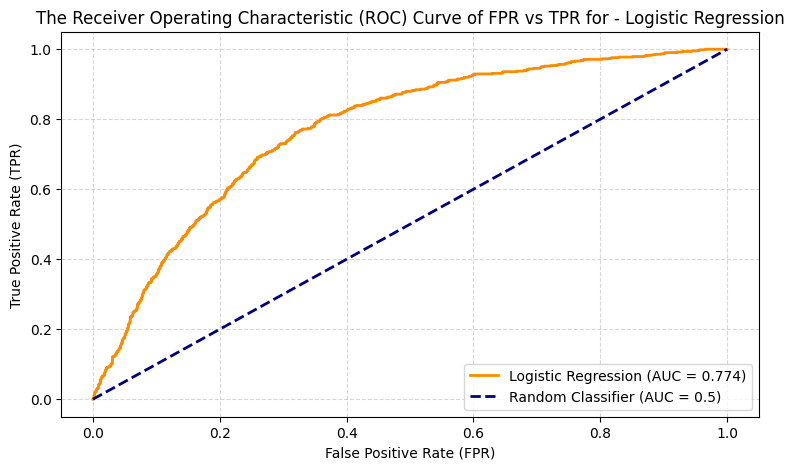

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


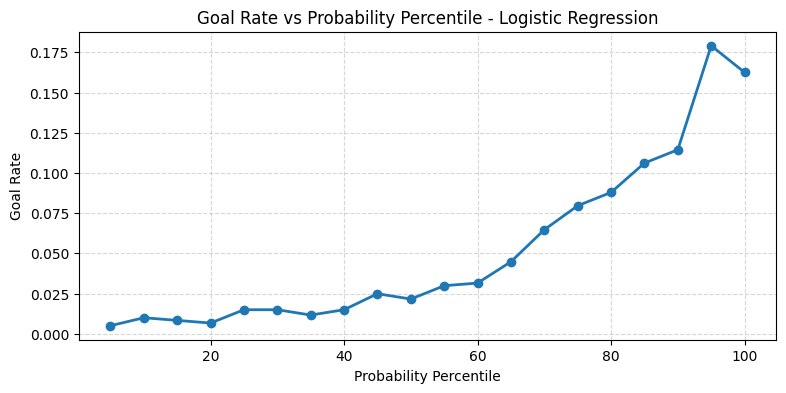

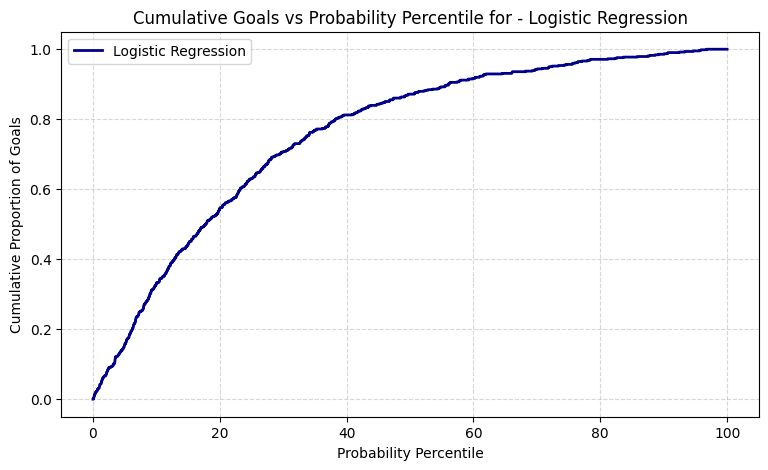

<Figure size 900x500 with 0 Axes>

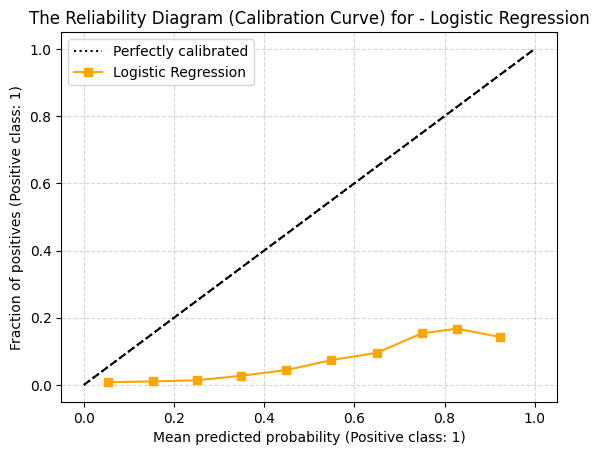

In [36]:
model_name = "Logistic Regression"
plot_roc(best_logreg, X_valid, y_valid, model_name=model_name)
print("")
plot_goal_rate_by_percentile(best_logreg, X_valid, y_valid, model_name=model_name)
print("")
plot_cum_prop_goals_by_prob(best_logreg, X_valid, y_valid, model_name=model_name)
print("")
plot_reliability_diagram(best_logreg, X_valid, y_valid, model_name=model_name)
print("")

Probability percentile: how confident we are that a shot is a goal

### KNN

In [37]:
knn = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

print("Best params:", grid_knn.best_params_)
print("Best CV AUC:", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

# Save the best model
# joblib.dump(best_knn, "best_knn_model.pkl")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best CV AUC: 0.9577073944187996


**Quantitative Metrics**

In [38]:
y_pred = best_knn.predict(X_valid)
report = classification_report(y_valid, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

precision    recall  f1-score       support
0              0.961094  0.829413  0.890412  11437.000000
1              0.109132  0.383628  0.169925    623.000000
accuracy       0.806385  0.806385  0.806385      0.806385
macro avg      0.535113  0.606520  0.530168  12060.000000
weighted avg   0.917083  0.806385  0.853192  12060.000000

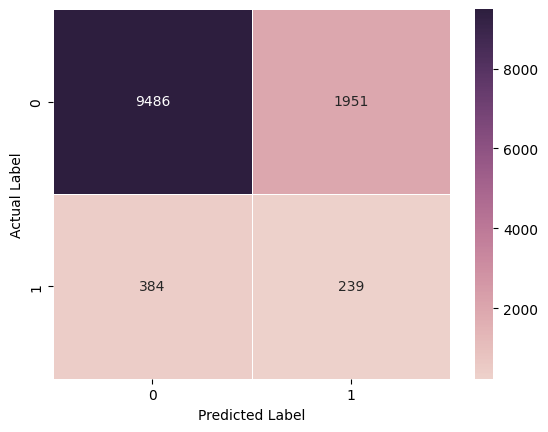

In [39]:
# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    name=f"KNN Confusion Matrix"
)
cf_matrix=confusion_matrix(y_valid, y_pred)
sns.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True),linewidth=.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
wandb.log({"KNN Confusion Matrix": wandb.Image(plt)})
plt.show()

wandb.finish()


The AUC Score is: 0.6846


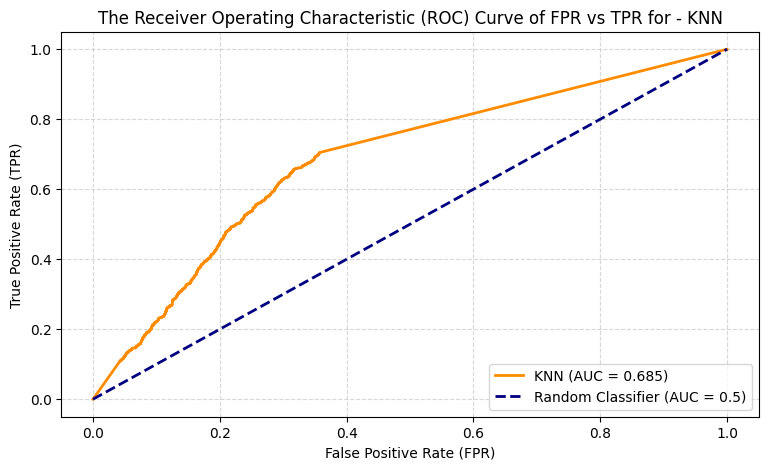

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


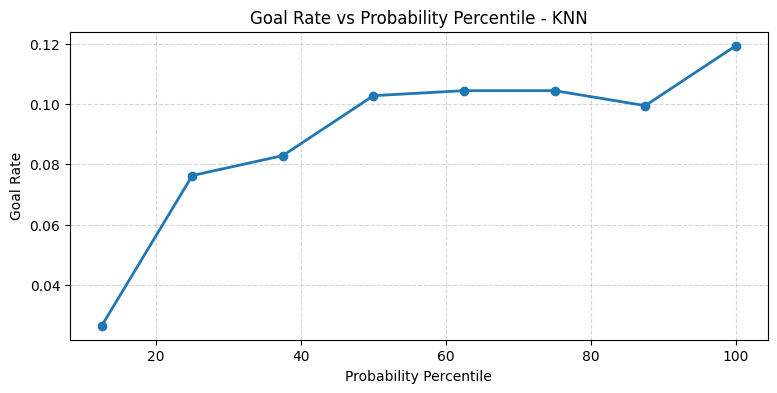

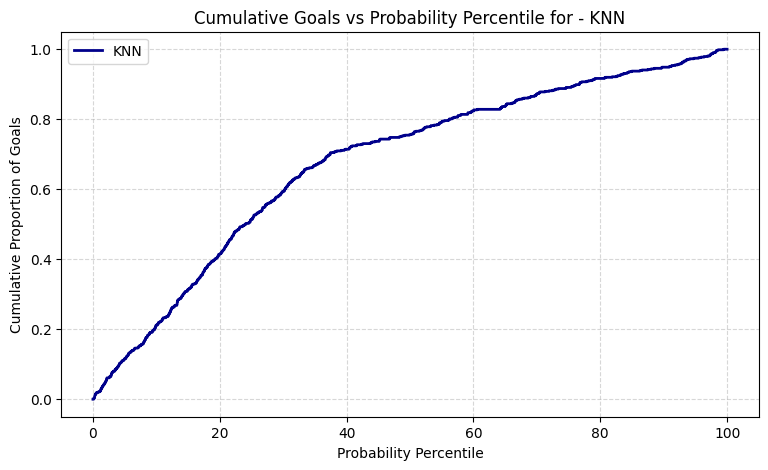

<Figure size 900x500 with 0 Axes>

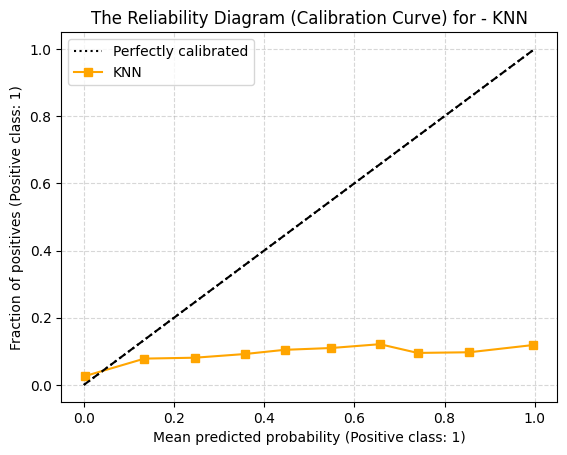

In [40]:
model_name = "KNN"
plot_roc(best_knn, X_valid, y_valid, model_name=model_name)
print("")
plot_goal_rate_by_percentile(best_knn, X_valid, y_valid, model_name=model_name)
print("")
plot_cum_prop_goals_by_prob(best_knn, X_valid, y_valid, model_name=model_name)
print("")
plot_reliability_diagram(best_knn, X_valid, y_valid, model_name=model_name)

### Random Forest

In [41]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 3, 5],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
print("RF best params:", grid_rf.best_params_)
print("RF best CV AUC:", grid_rf.best_score_)

# Test set AUC
best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
RF best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
RF best CV AUC: 0.9890608811446431


**Quantitative Metrics**

In [42]:
y_pred = best_rf.predict(X_valid)
report = classification_report(y_valid, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

precision    recall  f1-score       support
0              0.951577  0.965638  0.958556  11437.000000
1              0.134361  0.097913  0.113278    623.000000
accuracy       0.920813  0.920813  0.920813      0.920813
macro avg      0.542969  0.531776  0.535917  12060.000000
weighted avg   0.909361  0.920813  0.914890  12060.000000

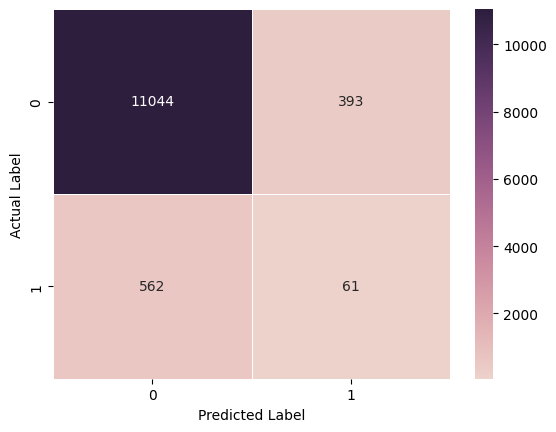

In [43]:
# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    name=f"Random Forest Confusion Matrix"
)
cf_matrix=confusion_matrix(y_valid, y_pred)
sns.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True),linewidth=.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
wandb.log({"Random Forest Confusion Matrix": wandb.Image(plt)})
plt.show()

wandb.finish()


The AUC Score is: 0.7348


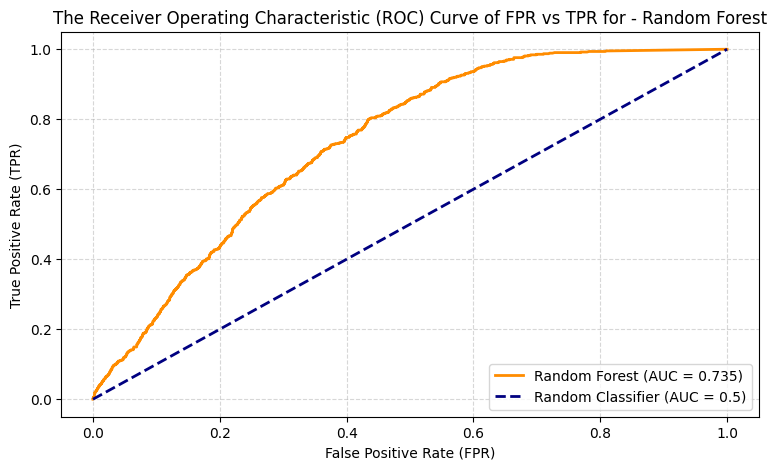

/tmp/ipykernel_169009/45377364.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


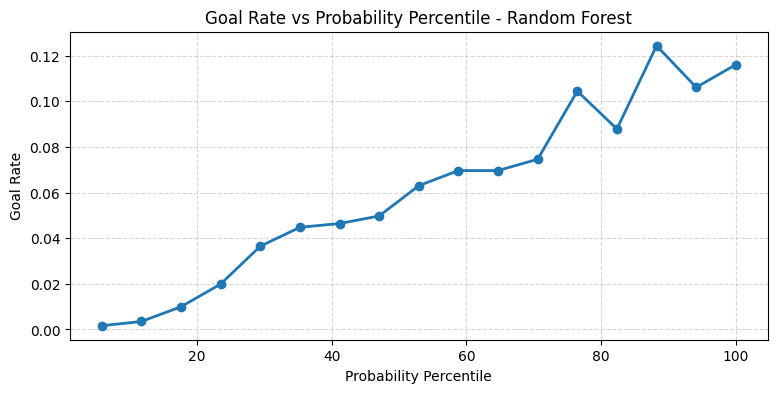

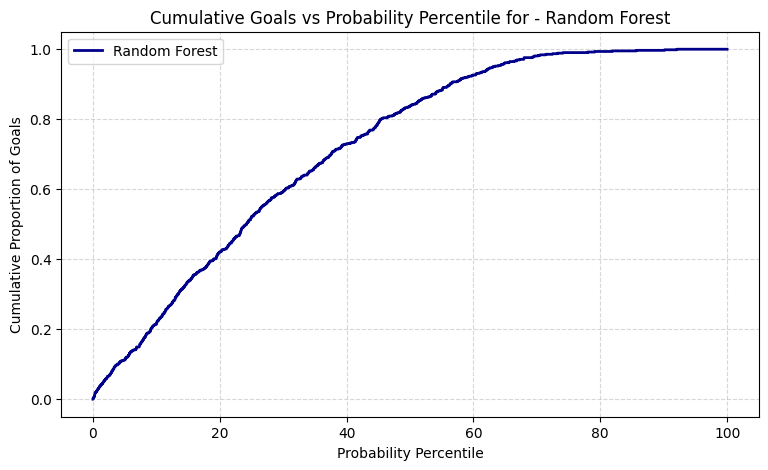

<Figure size 900x500 with 0 Axes>

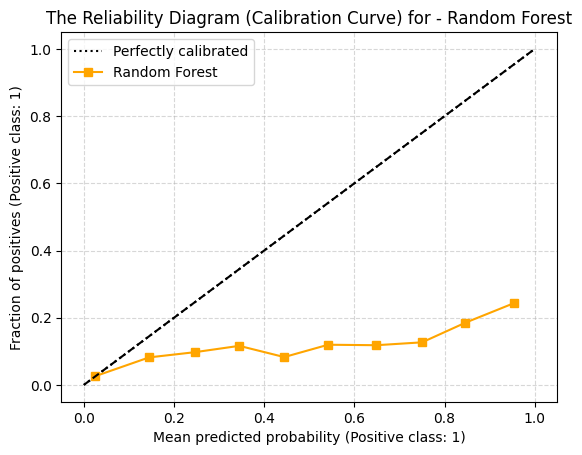

In [44]:
model_name = "Random Forest"
plot_roc(best_rf, X_valid, y_valid, model_name=model_name)
print("")
plot_goal_rate_by_percentile(best_rf, X_valid, y_valid, model_name=model_name)
print("")
plot_cum_prop_goals_by_prob(best_rf, X_valid, y_valid, model_name=model_name)
print("")
plot_reliability_diagram(best_rf, X_valid, y_valid, model_name=model_name)

### Neural Networks

In [45]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert NumPy arrays and Pandas Series to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Helper function for calculating accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc

In [47]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=X_train_tensor.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

neural_net = Model1().to(device)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.1)

# Fit the model
torch.manual_seed(42)
epochs = 200

# Start a run
run = wandb.init(
    project="IFT6758-Milestone2",
    name=f"Neural Network",
)

# Put all data on target device
X_train, y_train = X_train_tensor.to(device), y_train_tensor.to(device)
X_test, y_test = X_valid_tensor.to(device), y_valid_tensor.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = neural_net(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    neural_net.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = neural_net(X_test)
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

      wandb.log({
        "test_loss": test_loss,
        "test_acc": test_acc
      })

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

wandb.finish()

# Save the best model
# joblib.dump(neural_net, "neural_net_model.pkl")

Epoch: 0 | Loss: 0.69479, Accuracy: 47.44% | Test Loss: 0.70376, Test Accuracy: 37.72%
Epoch: 100 | Loss: 0.68019, Accuracy: 63.03% | Test Loss: 0.67457, Test Accuracy: 64.80%


**Quantitative Metrics**

In [48]:
with torch.inference_mode():
  test_logits = neural_net(X_test)
  test_pred = torch.round(torch.sigmoid(test_logits))

# Convert tensors to 1D NumPy arrays
y_true = y_test.detach().numpy().ravel()
y_pred = test_pred.detach().numpy().ravel()

report = classification_report(y_true, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()
results

precision    recall  f1-score       support
0.0            0.980669  0.643176  0.776851  11437.000000
1.0            0.104848  0.767255  0.184485    623.000000
accuracy       0.649585  0.649585  0.649585      0.649585
macro avg      0.542758  0.705215  0.480668  12060.000000
weighted avg   0.935426  0.649585  0.746250  12060.000000

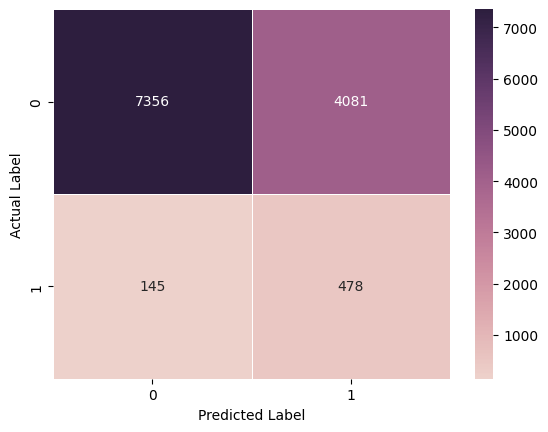

In [49]:
# Create a new run in a project
run = wandb.init(
    project="IFT6758-Milestone2",
    name=f"Neural Network Confusion Matrix"
)
cf_matrix=confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, annot=True,fmt=".0f", cmap=sns.cubehelix_palette(as_cmap=True),linewidth=.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
wandb.log({"Neural Network Confusion Matrix": wandb.Image(plt)})
plt.show()

wandb.finish()


The AUC Score is: 0.7472


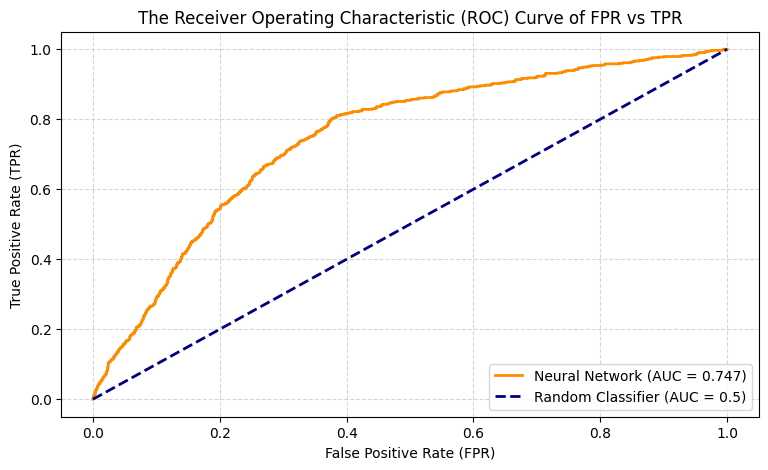

In [50]:
def plot_roc_nn(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} ROC score"
  )

  # 1. Gathering predicted probabilities for the positive class "goal"
  clf.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = clf(X_val)
    y_probas = torch.sigmoid(test_logits)
    test_pred = torch.round(y_probas) # logits -> prediction probabilities -> prediction labels
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_val)
    test_acc = accuracy_fn(y_true=y_val,
                            y_pred=test_pred)


  # 2. Computing the ROC curve
  fpr, tpr, boundaries = roc_curve(y_val, y_probas)

  # 3. Getting auc_score
  auc_score = roc_auc_score(y_val, y_probas)

  # 4. Plotting the ROC curve
  plt.figure(figsize=(9,5))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

  # 5. Setting The title
  plt.title("The Receiver Operating Characteristic (ROC) Curve of FPR vs TPR")

  # 6. Setting the x and y axis label
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")

  # 7. Plotting the legend
  plt.legend(loc="lower right")
  plt.grid(True, linestyle='--', alpha=0.5)

  # 9. Printing the AUC score
  print(f"\nThe AUC Score is: {auc_score:.4f}")
  # Log the plot as an image to W&B
  wandb.log({f"ROC Curve - {model_name}": wandb.Image(plt)})

  # 8. Plotting the graph
  plt.show()
  wandb.finish()

plot_roc_nn(neural_net, X_test, y_test, model_name="Neural Network")

/tmp/ipykernel_169009/282785477.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()


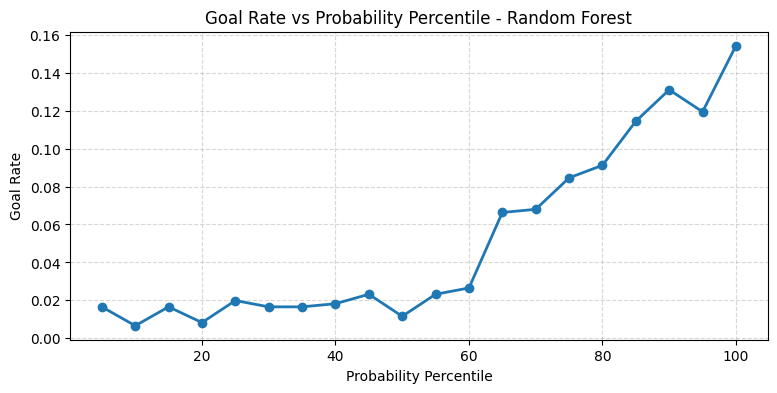

In [51]:
def plot_goal_rate_by_percentile_nn(clf, X_val, y_val):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} Goal Rate by Predicted Probability Percentile"
  )
  # 1. Compute predicted probabilities for the positive class "goal" and create a DataFrame that can be used for evaluation
  clf.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = clf(X_val)
    y_probas = torch.sigmoid(test_logits)
    test_pred = torch.round(y_probas) # logits -> prediction probabilities -> prediction labels
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_val)
    test_acc = accuracy_fn(y_true=y_val,
                            y_pred=test_pred)

  # 2. Create evaluation DataFrame
  df_evaluation = pd.DataFrame({
      "y_val": y_val.cpu().numpy().flatten(),
      "y_probas": y_probas.cpu().numpy().flatten()
  })

  # 3. Compute percentiles (20 bins = every 5th percentile)
  df_evaluation["percentile_bin"] = pd.qcut(df_evaluation["y_probas"], q=20, duplicates="drop")

  # 4. Compute goal rate per bin
  rate_of_goal = df_evaluation.groupby("percentile_bin")["y_val"].mean().reset_index()

  # 5. Convert percentile bins into 0–100 percentile ranks
  rate_of_goal["percentile_rank"] = (rate_of_goal.index + 1) * (100 / len(rate_of_goal))

  # 6. Plot line chart
  plt.figure(figsize=(9, 4))
  plt.plot(rate_of_goal["percentile_rank"], rate_of_goal["y_val"], marker='o', linewidth=2)
  plt.title(f"Goal Rate vs Probability Percentile - {model_name}")
  plt.xlabel("Probability Percentile")
  plt.ylabel("Goal Rate")
  plt.grid(True, linestyle='--', alpha=0.5)

  # Log the plot as an image to W&B
  wandb.log({f"Goal Rate by Predicted Probability Percentile - {model_name}": wandb.Image(plt)})

  # 6. Plotting the graph
  plt.show()
  wandb.finish()

plot_goal_rate_by_percentile_nn(neural_net, X_test, y_test)

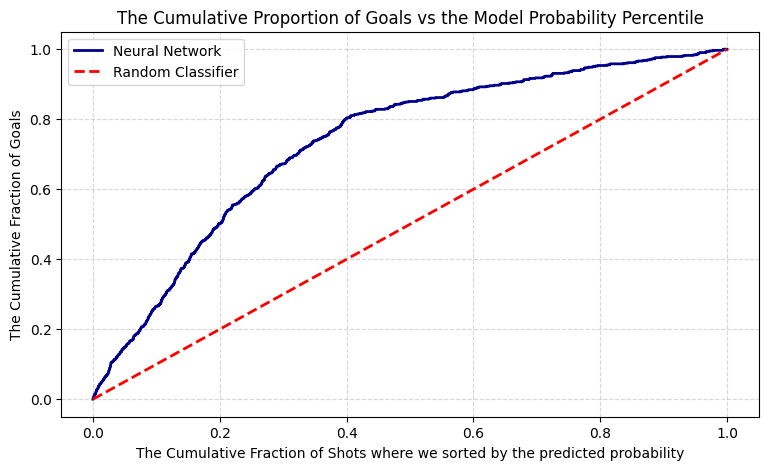

In [52]:
def plot_cum_prop_goals_by_prob_nn(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} Cumulative Proportion of Goals by Model Probability"
  )
  # 0. Compute predicted probabilities for the positive class "goal" and create a DataFrame that can be used for evaluation
  clf.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = clf(X_val)
    y_probas = torch.sigmoid(test_logits)
    test_pred = torch.round(y_probas) # logits -> prediction probabilities -> prediction labels
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_val)
    test_acc = accuracy_fn(y_true=y_val,
                            y_pred=test_pred)

  df_evaluation = pd.DataFrame({
      "y_val": y_val.numpy().flatten(),
      "y_probas": y_probas.numpy().flatten()
  })
  # 1. We will first sort the df_eval by the predicted probability values
  df_eval_sorted = df_evaluation.sort_values("y_probas", ascending=False)
  # 2. Calculating cumulative goals
  df_eval_sorted["cum_goals"] = df_eval_sorted["y_val"].cumsum()
  # 3. Calculating fraction of cumulative goals
  df_eval_sorted["fraction_cum_goals"] = df_eval_sorted["cum_goals"] / df_eval_sorted["y_val"].sum()
  # 4. Calculating fraction of cumulative shots
  df_eval_sorted["fraction_cum_shots"] = np.arange(len(df_eval_sorted)) / len(df_eval_sorted)

  # 5. Plotting cumulative goals vs shots
  plt.figure(figsize=(9,5))
  plt.plot(df_eval_sorted["fraction_cum_shots"], df_eval_sorted["fraction_cum_goals"], color='darkblue', lw=2, label=model_name)
  plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2, label="Random Classifier")
  # 6. Plottin the title, axis, and legend
  plt.title("The Cumulative Proportion of Goals vs the Model Probability Percentile")
  plt.xlabel("The Cumulative Fraction of Shots where we sorted by the predicted probability")
  plt.ylabel("The Cumulative Fraction of Goals")
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.5)

  # Log the plot as an image to W&B
  wandb.log({f"Cumulative Proportion of Goals by Model Probability - {model_name}": wandb.Image(plt)})

  plt.show()
  wandb.finish()

plot_cum_prop_goals_by_prob_nn(neural_net, X_test, y_test, model_name="Neural Network")

<Figure size 900x500 with 0 Axes>

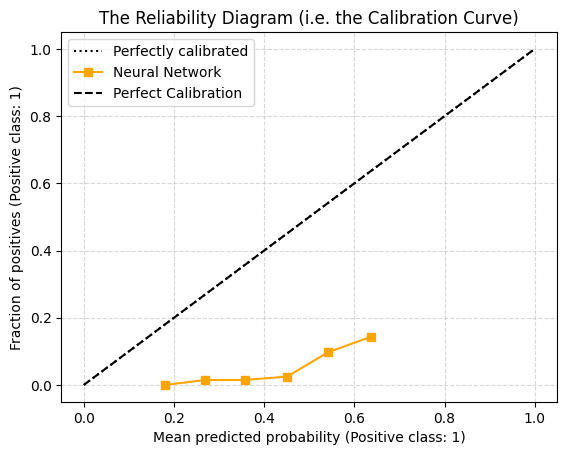

In [53]:
from sklearn.calibration import CalibrationDisplay

def plot_reliability_diagram_nn(clf, X_val, y_val, model_name):
  # Create a new run in a project
  run = wandb.init(
      project="IFT6758-Milestone2",
      name=f"{model_name} Calibration Curve"
  )
  # Get predicted probabilities from the PyTorch model
  clf.eval()
  with torch.inference_mode():
    test_logits = clf(X_val)
    y_probas = torch.sigmoid(test_logits)

  # 1. Plotting figure and Calibration Display for Reliability diagram
  plt.figure(figsize=(9,5))
  CalibrationDisplay.from_predictions(
      y_val.numpy(), y_probas.numpy(), n_bins=10, name=model_name, color='orange'
  )

  # 2. Plotting the plot, title, grid, and legend
  plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Perfect Calibration")
  plt.title("The Reliability Diagram (i.e. the Calibration Curve)")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend()

  # Log the plot as an image to W&B
  wandb.log({f"Calibration Curve - {model_name}": wandb.Image(plt)})

  plt.show()
  wandb.finish()

plot_reliability_diagram_nn(neural_net, X_test, y_test, model_name="Neural Network")

In [54]:
### Saving all models
run = wandb.init(
    project="IFT6758-Milestone2",
    name="Section 6 models"
)

artifact = wandb.Artifact(
    name="Section-6-Models",
    type="model"
)

# Save and log the best logistic regression model
joblib.dump(best_logreg, "best_lr_model.pkl")
artifact.add_file("best_lr_model.pkl")

# Save and log the best knn model
joblib.dump(best_knn, "best_knn_model.pkl")
artifact.add_file("best_knn_model.pkl")

# Save and log the best random forest model
joblib.dump(best_rf, "best_rf_model.pkl")
artifact.add_file("best_rf_model.pkl")

# Save and log the best neural network model
joblib.dump(neural_net, "best_nn_model.pkl")
artifact.add_file("best_nn_model.pkl")

run.log_artifact(artifact)
run.finish()

# **7. Evaluate on Test**

wandb:   1 of 1 files downloaded.  


 Loaded distance model from /home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/artifacts/logreg_distance:v6/logreg_distance.pkl



wandb:   1 of 1 files downloaded.  


 Loaded angle model from /home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/artifacts/logreg_angle:v6/logreg_angle.pkl



wandb:   1 of 1 files downloaded.  


 Loaded distance_angle model from /home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/artifacts/logreg_distance_angle:v6/logreg_distance_angle.pkl

Regular season samples: 94320 | Playoff samples: 9996

=== Evaluating Logistic Regression Models on Regular Season ===


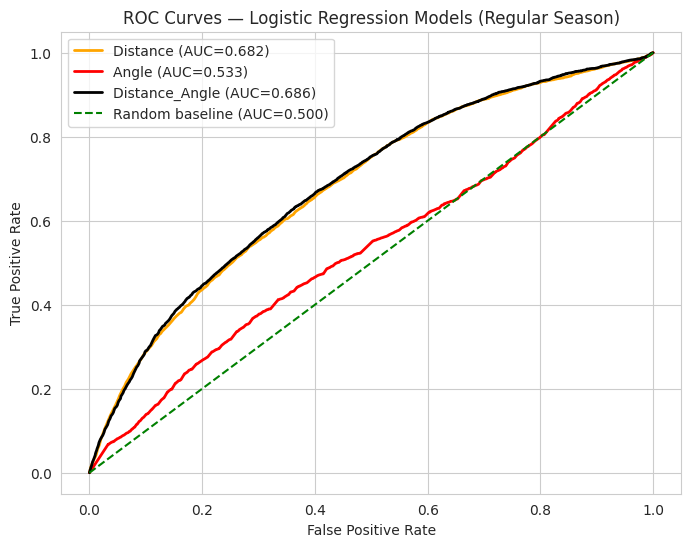

/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("perce

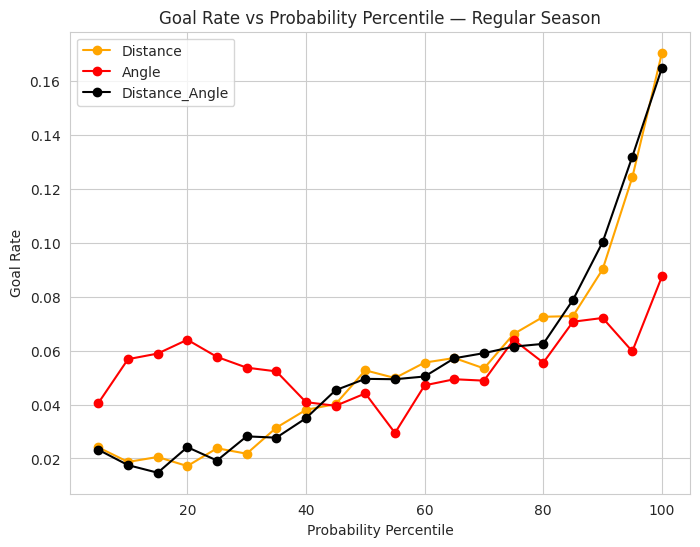

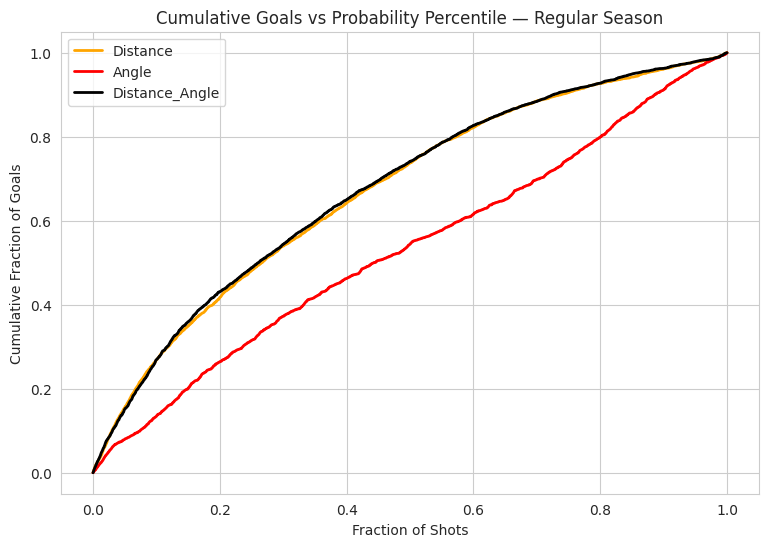

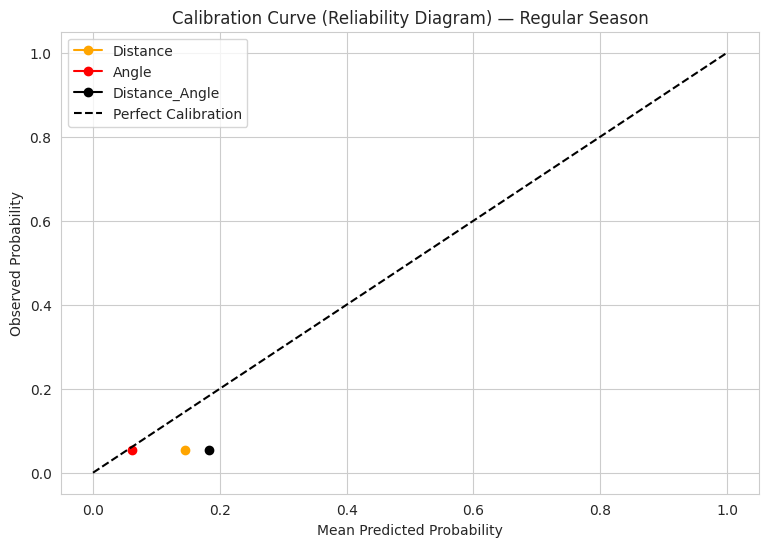


=== Evaluating Logistic Regression Models on Playoffs ===


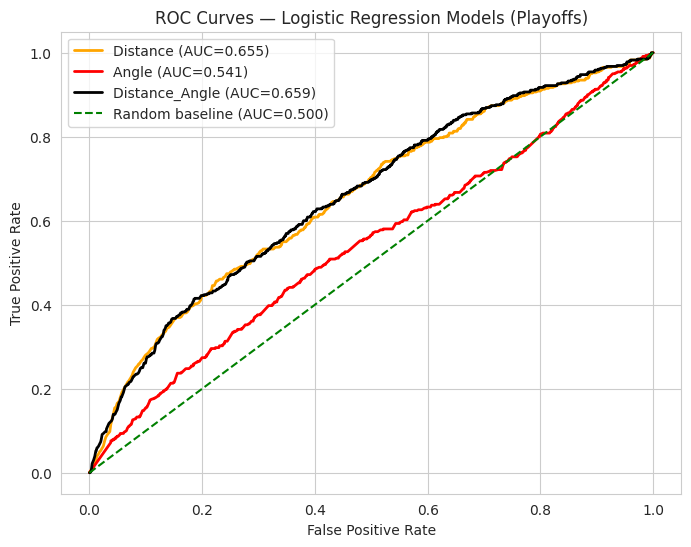

/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
/tmp/ipykernel_169009/4092703246.py:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("perce

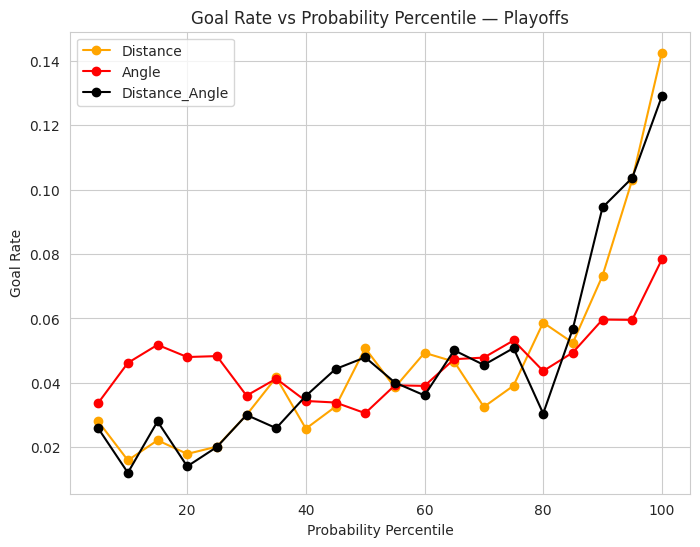

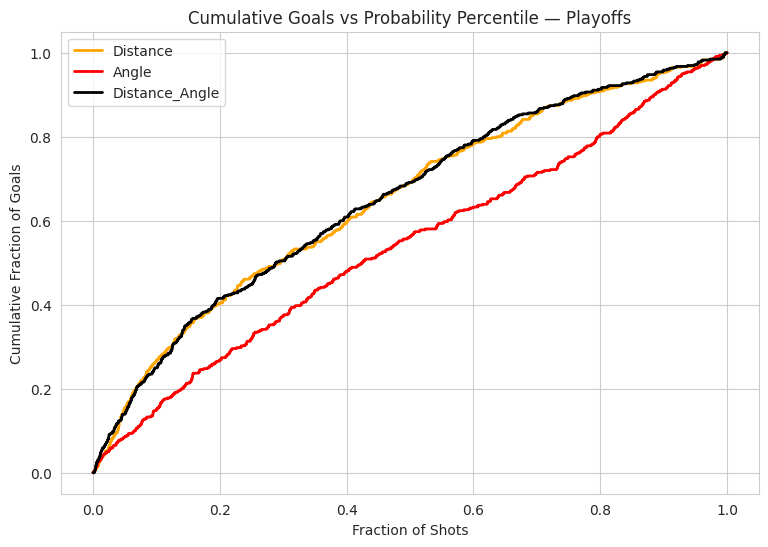

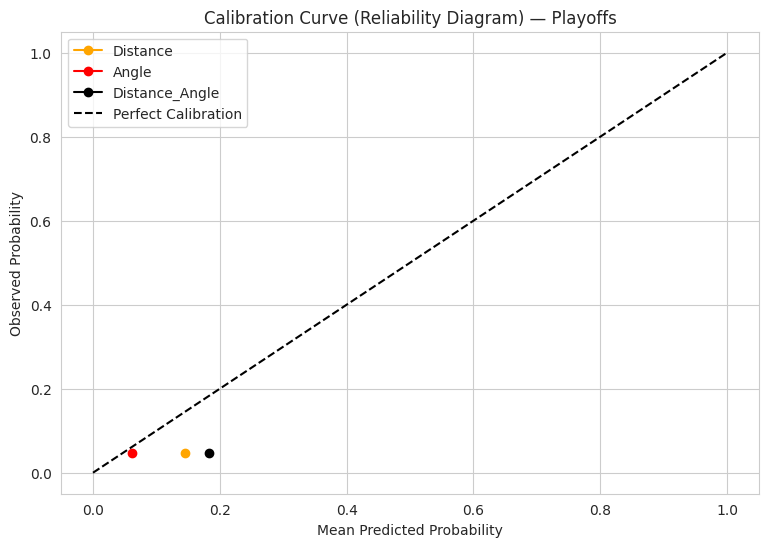


 Completed evaluation of all Logistic Regression models for both test sets.


In [55]:
# Evaluate Logistic Regression Models (2020–21 Regular + Playoff)

# 1. Setting the Style Grid
sns.set_style("whitegrid")

# 2. Initializing the W&B session to access the Log Reg model defined in section 3
wandb.login()
entity_name = "IFT6758-2025-B08"
project_name = "IFT6758-Milestone2"

run = wandb.init(
    entity=entity_name,
    project=project_name,
    name="Q7 - Evaluate Logistic Regression Models"
)

# 3. Load pretrained Log Reg models defined in Section 3 from W&B artifacts
artifact_names = {
    "distance": f"{entity_name}/{project_name}/logreg_distance:latest",
    "angle": f"{entity_name}/{project_name}/logreg_angle:latest",
    "distance_angle": f"{entity_name}/{project_name}/logreg_distance_angle:latest"
}

# 4. Defining Models
models = {}
# Defining key and artifact_path in artifact_names
for key, artifact_path in artifact_names.items():
    print(f"\n Downloading artifact: {artifact_path}")
    artifact = wandb.use_artifact(artifact_path, type="model")
    artifact_dir = artifact.download()
    # Extracting the relevant pkl_files
    pkl_files = [f for f in os.listdir(artifact_dir) if f.endswith(".pkl")]
    if not pkl_files:
        raise FileNotFoundError(f"No .pkl file found in {artifact_dir}")
    # Defining model_file and models[key] for the original Log Reg models
    model_file = os.path.join(artifact_dir, pkl_files[0])
    models[key] = joblib.load(model_file)
    print(f" Loaded {key} model from {model_file}")

# 5 Loading and prepare the 2020–21 NHL dataset which was first defined in section 2 a)
df = test_final_df.copy()

# 6. Defining function prepare_shot_data which adds columns which makes data easier to evaluate
# Essentially we are replicating the tidy data steps up to section 3
def prepare_shot_data(df):
    # Defining typeDescKey as shot-on-goal and goal
    shots = df[df["typeDescKey"].isin(["shot-on-goal", "goal", 'missed-shot', 'blocked-shot'])].copy()
    # Defining x and y standardized
    shots["x_standardized"] = np.where(shots["details_xCoord"] < 0, -shots["details_xCoord"], shots["details_xCoord"])
    shots["y_standardized"] = np.where(shots["details_xCoord"] < 0, -shots["details_yCoord"], shots["details_yCoord"])
    x_net, y_net = 89, 0
    # Defining distance from the net
    shots["distance_from_net"] = np.sqrt((x_net - shots["x_standardized"])**2 + (y_net - shots["y_standardized"])**2)
    # Defining angle from the net
    shots["angle_from_net"] = np.degrees(np.arctan2(abs(y_net - shots["y_standardized"]), abs(x_net - shots["x_standardized"])))
    # Defining is_goal column
    shots["is_goal"] = (shots["typeDescKey"] == "goal").astype(int)
    # Defining empty_net column
    shots["empty_net"] = shots["details_goalieInNetId"].isna().astype(int)
    # Returning shots
    return shots

# Defining test dta frame
#test_df = df[df["season"].astype(str) == "20202021"]
test_shots = prepare_shot_data(df)

# 7. Separating Regular and Playoff Games
test_shots["game_id"] = test_shots["id"].astype(str).str.zfill(10)
# 8. Defining game_type based on game_id
test_shots["game_type"] = test_shots["game_id"].str[4:6]
# Defining reg_test and playoff_test
reg_test = test_shots[test_shots["game_type"] == "02"]
playoff_test = test_shots[test_shots["game_type"] == "03"]

print(f"\nRegular season samples: {len(reg_test)} | Playoff samples: {len(playoff_test)}")

# 9. Features
features = {
    "distance": ["distance_from_net"],
    "angle": ["angle_from_net"],
    "distance_angle": ["distance_from_net", "angle_from_net"]
}

# 10. Combining the plotting function
# Do not reuse plotting functions from section 3 due to pulling models from Wandb
def plot_combined_curves(models, X_dict, y_dict, label):
    colors = {
        "distance": "orange",
        "angle": "red",
        "distance_angle": "black",
        "random": "green"
    }

    y_test = y_dict["distance"]

    # 11. Plotting the ROC Curve
    plt.figure(figsize=(8, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, color=colors[key], lw=2, label=f"{key.title()} (AUC={auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "--", color=colors["random"], label="Random baseline (AUC=0.500)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — Logistic Regression Models ({label})")
    plt.legend()
    wandb.log({f"ROC Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 12. Plotting the Goal Rate vs Probability Percentile
    plt.figure(figsize=(8, 6))
    # Iterate through models.keys()
    for key in models.keys():
        # Similar to section 3 curves, define y_proba, df_eval, rate, and other columns
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba})
        df_eval["percentile_bin"] = pd.qcut(df_eval["y_proba"], q=20, duplicates="drop")
        rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
        rate["percentile_rank"] = (rate.index + 1) * (100 / len(rate))
        plt.plot(rate["percentile_rank"], rate["y"], marker="o", color=colors[key], label=key.title())
    plt.xlabel("Probability Percentile")
    plt.ylabel("Goal Rate")
    plt.title(f"Goal Rate vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Goal Rate Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 13. Defining Cumulative Goals similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba}).sort_values("y_proba", ascending=False)
        df_eval["cum_goals"] = df_eval["y"].cumsum()
        df_eval["cum_goals_frac"] = df_eval["cum_goals"] / df_eval["y"].sum()
        df_eval["cum_shots_frac"] = np.arange(len(df_eval)) / len(df_eval)
        plt.plot(df_eval["cum_shots_frac"], df_eval["cum_goals_frac"], lw=2, color=colors[key], label=key.title())
    plt.xlabel("Fraction of Shots")
    plt.ylabel("Cumulative Fraction of Goals")
    plt.title(f"Cumulative Goals vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Cumulative Goals Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 14. Plotting the Calibration Curve similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
        plt.plot(prob_pred, prob_true, "o-", color=colors[key], label=key.title())
    plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Observed Probability")
    plt.title(f"Calibration Curve (Reliability Diagram) — {label}")
    plt.legend()
    wandb.log({f"Calibration Combined — {label}": wandb.Image(plt)})
    plt.show()

# 15. Evaluating on the Regular and Playoff Data
for label, df_test in [("Regular Season", reg_test), ("Playoffs", playoff_test)]:
    print(f"\n=== Evaluating Logistic Regression Models on {label} ===")
    run = wandb.init(entity=entity_name, project=project_name, name=f"Q7 - Logistic Regression on {label}")

    # 16. Defining the evaluation
    X_dict, y_dict = {}, {}
    for key, model in models.items():
        current_features = features[key]
        # Applying STandad Scaler and fit transform 
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_test[current_features].fillna(df_test[current_features].median()))
        # Defiing Features
        X_dict[key] = pd.DataFrame(X_scaled, columns=current_features)
        # Defining Target
        y_dict[key] = df_test["is_goal"]

    # 17. Plotting the combined features
    plot_combined_curves(models, X_dict, y_dict, label)
    run.finish()

print("\n Completed evaluation of all Logistic Regression models for both test sets.")

In [56]:
### Running the same preprocessings on the test dataset
# 3. Filtering only on shot-on-goal and goal events
shots_df = test_final_df[test_final_df['typeDescKey'].isin(['shot-on-goal', 'goal', 'missed-shot', 'blocked-shot'])].copy()

# 4. Standardizing the direction of all shots to ensure that they face the same net
shots_df['x_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_xCoord'],
                                      shots_df['details_xCoord'])
shots_df['y_standardized'] = np.where(shots_df['details_xCoord'] < 0,
                                      -shots_df['details_yCoord'],
                                      shots_df['details_yCoord'])

# 5. Calculate the angles from the net and distance from the net
# We assume that the net can be at the position (89, 0)
def compute_angles_distance(x,y):
  x_net, y_net = 89, 0
  dx = x_net - x
  dy = y_net - y
  # Defining Distance and Angles
  dist = np.sqrt(dx**2 + dy**2)
  # Angles are converted to degrees
  ang = np.degrees(np.arctan2(abs(dy), abs(dx)))
  return dist, ang


# 6. Defining the Shots Data frame
shots_df['distance_from_net'], shots_df['angle_from_net'] = zip(*shots_df.apply(lambda r: compute_angles_distance(r["x_standardized"], r["y_standardized"]), axis=1))

# 7. Creating the Is Goal and Empty Net column
shots_df["is_goal"] = np.where(shots_df["typeDescKey"]== "goal", 1, 0)
shots_df["empty_net"] = np.where(
    shots_df["details_goalieInNetId"].isna(), 1, 0
)


# 8. Selecting the final tidy data set for shots
tidy_shots_data = shots_df[['distance_from_net', 'angle_from_net', 'is_goal', 'empty_net', 'season']]

# 1. Dropping NA values from distance and is goal
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "is_goal"])

# Drop NAs from distance_from_net, angle_from_net, and is_goal
tidy_shots_data = tidy_shots_data.dropna(subset=["distance_from_net", "angle_from_net", "is_goal"])

# 1. Start from your initial shots_df data set
df_shots = shots_df.copy()

# 2. Creating the Game Seconds column by breaking down and recombining the timeInPeriod column
# Specifically we convert time string "MM:SS" to total seconds
df_shots["game_seconds"] = df_shots["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)

# 3. We can use existing columns and rename them to game period along with the x and y coordinates, also adding in game_id and game_seconds
df_shots["game_id"] = df_shots["id"]
df_shots["game_period"] = df_shots["periodDescriptor_number"]
df_shots["x_coord"] = df_shots["x_standardized"]
df_shots["y_coord"] = df_shots["y_standardized"]

# 4. Renaming columns to obtain shot distance, shot angle, and shot type
df_shots.rename(columns={
    "distance_from_net": "shot_distance",
    "angle_from_net": "shot_angle",
    "typeDescKey": "shot_type"
}, inplace=True)

# 5. Selecting final tidy dataset with all the required columns
tidy_data_updated = df_shots[["game_id",
    "game_seconds",
    "game_period",
    "x_coord", "y_coord",
    "shot_distance", "shot_angle",
    "shot_type",
    "is_goal", "empty_net", "season"
]].copy()

all_games_df["game_id"] = all_games_df["id"]

events_df = all_games_df.copy().sort_values(by=["game_id", "eventId"]).reset_index(drop=True)

# 3. Computing the total game seconds (this would include the period time and the period offset time)
events_df["seconds_of_period"] = events_df["timeInPeriod"].apply(
    lambda t: int(t.split(":")[0]) * 60 + int(t.split(":")[1]) if isinstance(t, str) else np.nan
)
events_df["game_seconds"] = (events_df["periodDescriptor_number"] - 1) * 1200 + events_df["seconds_of_period"]

# 4. Obtain the immediately preceding event information for every NHL game
events_df["last_event_type"] = events_df.groupby("game_id")["typeDescKey"].shift(1)
events_df["last_event_x_coord"] = events_df.groupby("game_id")["details_xCoord"].shift(1)
events_df["last_event_y_coord"] = events_df.groupby("game_id")["details_yCoord"].shift(1)
events_df["last_event_time"] = events_df.groupby("game_id")["game_seconds"].shift(1)

# 5. Computing time since the last event
events_df["time_since_last_event"] = events_df["game_seconds"] - events_df["last_event_time"]
events_df["distance_from_last_event"] = np.sqrt(
    (events_df["details_xCoord"] - events_df["last_event_x_coord"])**2 +
    (events_df["details_yCoord"] - events_df["last_event_y_coord"])**2
)

# 6. Filtering events_df to only shot-related events, note this mirrors shots_df_updated
shots_with_prev = events_df[events_df["typeDescKey"].isin(["shot-on-goal", "goal"])].copy()

# 7. Keep only columns you need for merging
shots_with_prev_events = shots_with_prev[[
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]]

# 8. Defining the columns that will be merged on
merge_cols = [
    "game_id", "game_seconds",
    "last_event_type", "last_event_x_coord", "last_event_y_coord",
    "time_since_last_event", "distance_from_last_event"
]

# 9. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in merge_cols if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 10. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated = tidy_data_updated.merge(
    shots_with_prev[merge_cols],
    on=["game_id", "game_seconds"],
    how="left"
)


# 1. Creating data frame of shots only feature including goals or shot-on-goal
shots_only_features = tidy_data_updated.copy()

# 2. Creating the rebound column which is true if the most recent event was a shot
shots_only_features["rebound"] = shots_only_features["last_event_type"].isin(["shot-on-goal", "goal"])

# 3. Creating the Shot Angle colum whereh shot is a rebound and otherwise set to 0
# Convert from radians to degrees
shots_only_features["change_in_shot_angle"] = np.where(
    shots_only_features["rebound"],
    np.abs(shots_only_features["shot_angle"] - np.arctan2(
        shots_only_features["y_coord"] - shots_only_features["last_event_y_coord"],
        shots_only_features["x_coord"] - shots_only_features["last_event_x_coord"]
    ) * 180 / np.pi),
    0
)

# 4. Creating the speed column divided with the formula distance from previous event/time from previous event)
# Consider possible divide by zero case
shots_only_features["speed"] = np.where(
    (shots_only_features["time_since_last_event"] > 0) & (~shots_only_features["time_since_last_event"].isna()),
    shots_only_features["distance_from_last_event"] / shots_only_features["time_since_last_event"],
    np.nan
)

# 5. Clean up extreme values (optional but good practice)
shots_only_features.loc[shots_only_features["speed"] > 1000, "speed"] = np.nan

# 6. View the resulting columns to make sure everything is added properly

# 7. Updating your main tidy dataset and make sure everything is correct
tidy_data_updated = shots_only_features


# 1. Analyze situation code to obtain Power Play Details (
power_play_df = all_games_df.copy()
power_play_df["game_id"] = power_play_df["id"]

# 2. Clean up situationCode safely before using extract_skaters
power_play_df["situationCode"] = (
    power_play_df["situationCode"]
    .astype(str)                       # convert everything to string
    .str.strip()                       # remove spaces around
    .str.replace(r"\.0$", "", regex=True)  # drop trailing .0 from floats
    .replace(["None", "nan", "NaN", "NULL", "NoneType"], np.nan)  # handle text NaNs
)

# 3. Keep only rows with purely numeric 3- or 4-digit codes
mask = power_play_df["situationCode"].str.match(r"^\d{3,4}$", na=False)
power_play_df = power_play_df[mask].copy()

# 4. Apply Extract Skaters column
def extract_skaters(code):
    code = str(int(code))
    if len(code) == 4:
        return int(code[1]), int(code[2])
    elif len(code) == 3:
        return int(code[0]), int(code[1])
    else:
        return np.nan, np.nan

pairs = [extract_skaters(c) for c in power_play_df["situationCode"]]
if pairs:
    home, away = zip(*pairs)
else:
    home, away = ([], [])

# 5. Define Home and Away skaters
power_play_df["home_skaters"] = home if len(home) else np.nan
power_play_df["away_skaters"] = away if len(away) else np.nan


# 6. Computing whether a power play is actually happening
invalid_codes = ["101", "560", "660"]
power_play_df["valid_power_play"] = (
    (power_play_df["home_skaters"] != power_play_df["away_skaters"]) &
    (~power_play_df["situationCode"].astype(str).isin(invalid_codes))
)

# 7. Now we identify which team is on the power play
power_play_df["power_play_team"] = np.where(
    power_play_df["home_skaters"] > power_play_df["away_skaters"], "home",
    np.where(power_play_df["away_skaters"] > power_play_df["home_skaters"], "away", None)
)

# 8. Computing the total game seconds, similar to the methods employed before (This is where we convert MM:SS to total seconds + add period offset)
power_play_df["seconds_in_period"] = power_play_df["timeInPeriod"].apply(
    lambda time: int(time.split(":")[0]) * 60 + int(time.split(":")[1]) if isinstance(time, str) else np.nan
)
power_play_df["game_seconds"] = (
    (power_play_df["periodDescriptor_number"] - 1) * 1200 + power_play_df["seconds_in_period"]
)

# 9. Sorting chronologically within each game in order to make the data set easier to read
power_play_df = power_play_df.sort_values(by=["id", "game_seconds"]).reset_index(drop=True)

# 10. Calculating the "time since power play started"
# Initially set it to 0
power_play_df["time_since_power_play_start"] = 0.0

# 11. Iterating through id and game events
for game_id, game_events in power_play_df.groupby("id"):
    last_pp_start_time = None
    times = []
    for _, r in game_events.iterrows():
        if r["valid_power_play"]:
            # 9. We first start the power play if power play is not already active
            if last_pp_start_time is None:
                last_pp_start_time = r["game_seconds"]
            times.append(r["game_seconds"] - last_pp_start_time)
        else:
            # 10. We reset timer when player returns to even strength
            last_pp_start_time = None
            times.append(0)
    power_play_df.loc[game_events.index, "time_since_power_play_start"] = times

# 12. Assigning the friendly and opposition's non-goalie skater counts in relation to each event's team
power_play_df["friendly_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["home_skaters"],
    power_play_df["away_skaters"]
)
power_play_df["opposing_skaters"] = np.where(
    power_play_df["details_eventOwnerTeamId"] == power_play_df["homeTeam_id"],
    power_play_df["away_skaters"],
    power_play_df["home_skaters"]
)

# 13. We select only the power play features for power_play_df we will use for merging
power_play_features = power_play_df[[
    "game_id",
    "game_seconds",
    "time_since_power_play_start",
    "friendly_skaters",
    "opposing_skaters"
]].drop_duplicates(subset=["game_id", "game_seconds"])


# 14. Before executing the merge, explicitly remove these columns from the tidy_data_updated if they already exist there to avoid duplicate column creation
tidy_data_updated = tidy_data_updated.drop(
    columns=[c for c in power_play_features if c in tidy_data_updated.columns and c not in ["game_id", "game_seconds"]],
    errors="ignore"
)

# 15. Perform the left merge between tidy_data_updated and shots_with_prev
tidy_data_updated_test = tidy_data_updated.merge(
    power_play_features,
    on=["game_id", "game_seconds"],
    how="left"
)

# 16. Removing the redundant 'id' column created during merge (if it exists) as it is irrelevant to the tidy data set as it has the game_id column
if "id" in tidy_data_updated_test.columns:
    tidy_data_updated_test.drop(columns=["id"], inplace=True)

# # 17. Creating game_type columns
# tidy_data_updated_test["game_type"] = tidy_data_updated_test["game_id"].astype(str).str[4:6]

# 18. Print out tidy data columns
print("These are the list of tidy_data_updated_test columns: ", tidy_data_updated_test.columns)

These are the list of tidy_data_updated_test columns:  Index(['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord',
       'shot_distance', 'shot_angle', 'shot_type', 'is_goal', 'empty_net',
       'season', 'last_event_type', 'last_event_x_coord', 'last_event_y_coord',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'change_in_shot_angle', 'speed', 'time_since_power_play_start',
       'friendly_skaters', 'opposing_skaters'],
      dtype='object')


wandb:   1 of 1 files downloaded.  


 Loaded xgb model from /home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/artifacts/XGB-Models:v4/best_xgb_model_with_feature_selection.pkl

Regular season samples: 94507 | Playoff samples: 10014

=== Evaluating XGBoost Model on Regular Season ===


Missing values before handling: 638272
Missing values after handling: 0


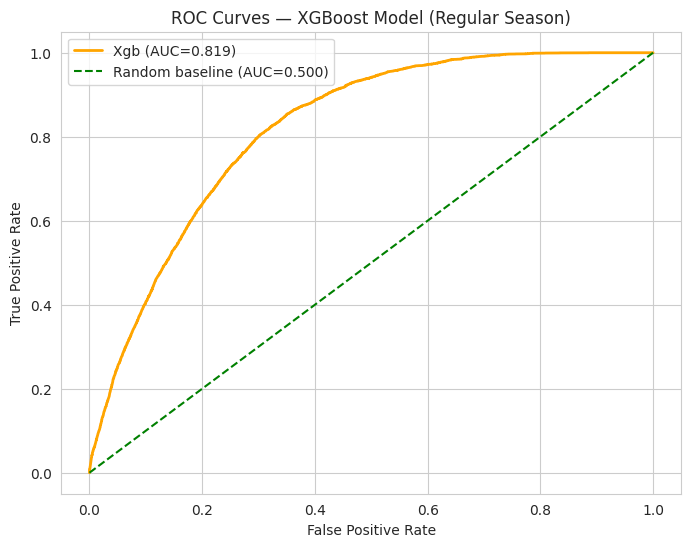

/tmp/ipykernel_169009/1555919142.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()


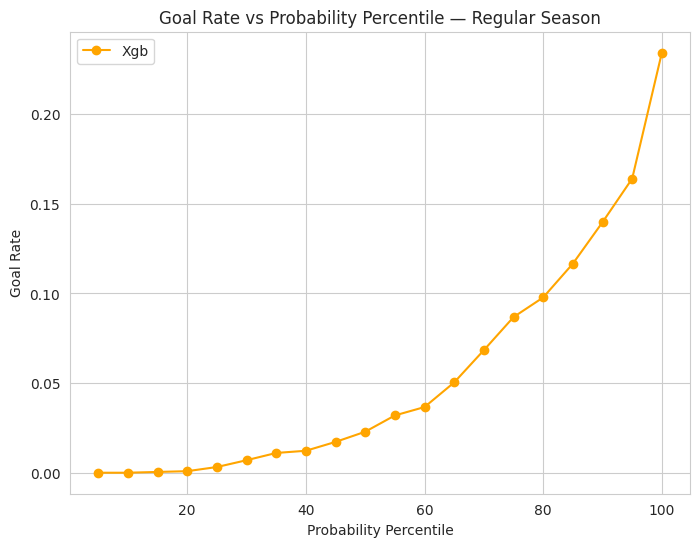

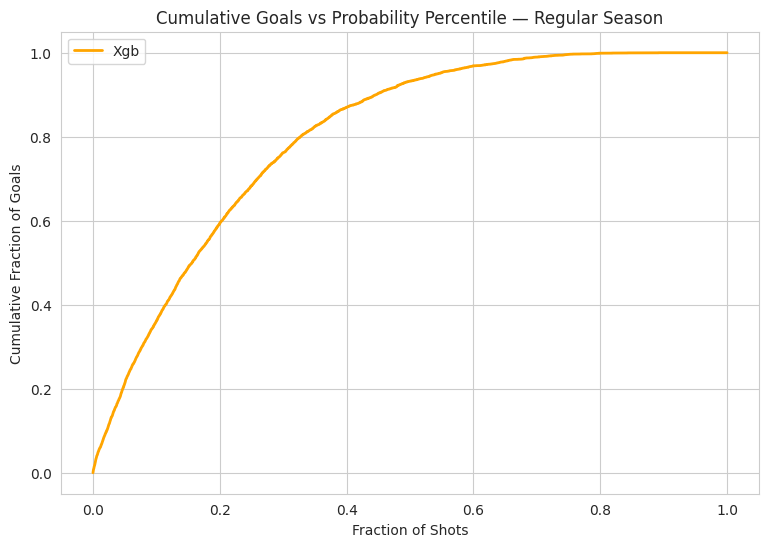

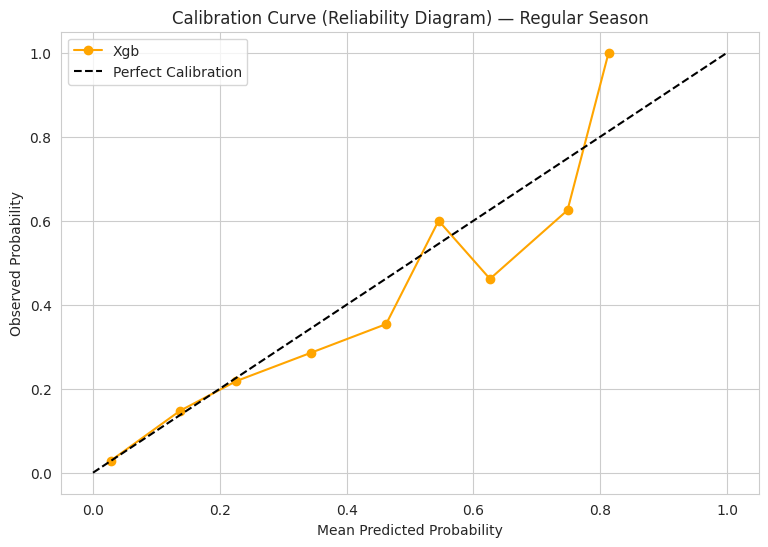


=== Evaluating XGBoost Model on Playoffs ===


Missing values before handling: 68159
Missing values after handling: 0


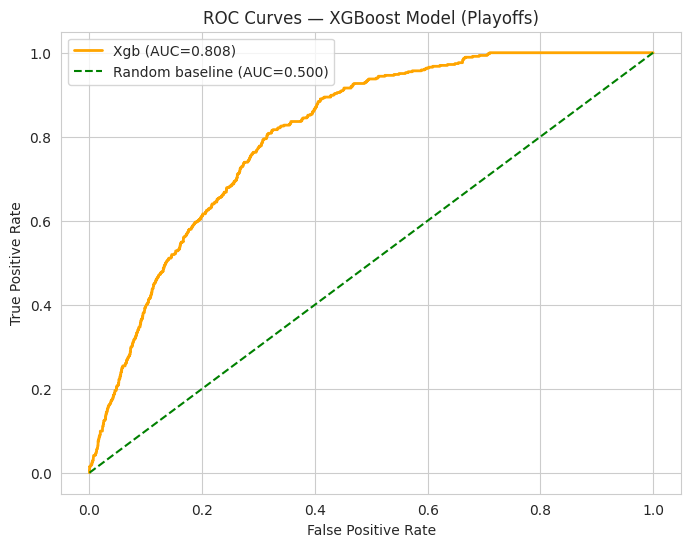

/tmp/ipykernel_169009/1555919142.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()


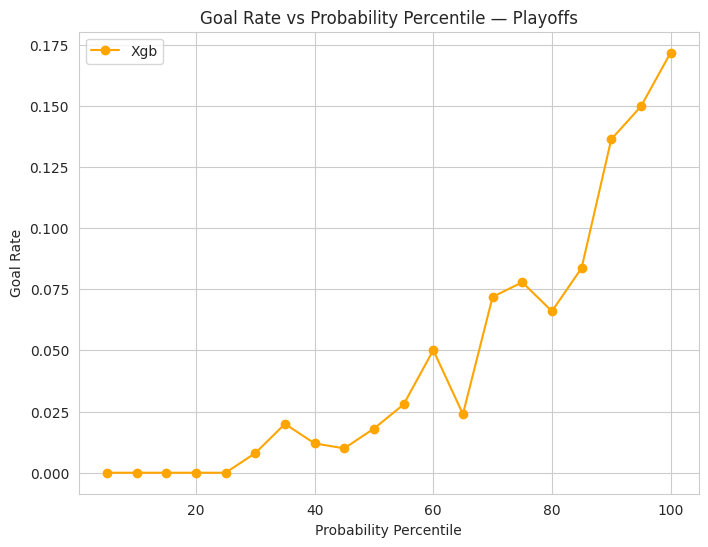

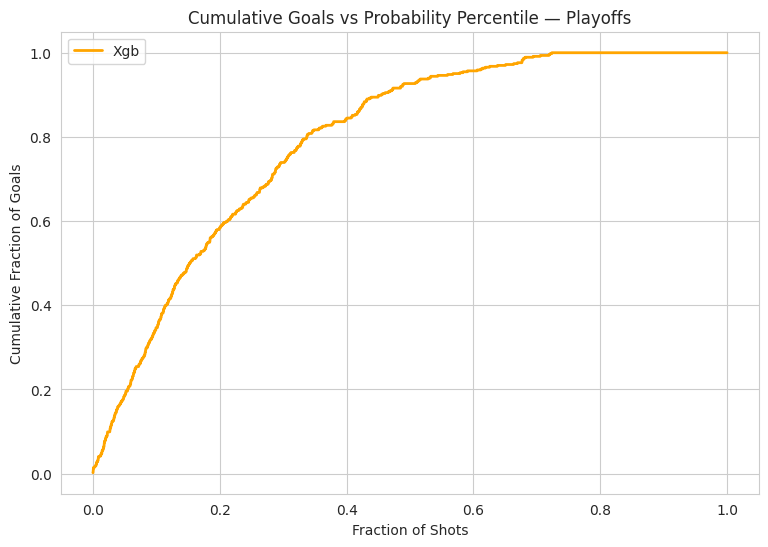

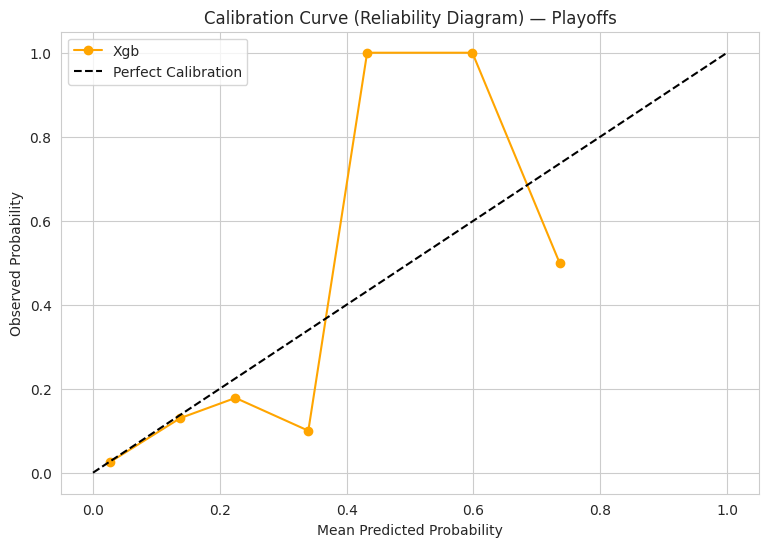


 Completed evaluation of all Logistic Regression models for both test sets.


In [57]:
# Evaluate Logistic Regression Models (2020–21 Regular + Playoff)

# 1. Setting the Style Grid
sns.set_style("whitegrid")

# 2. Initializing the W&B session to access the Log Reg model defined in section 3
wandb.login()
entity_name = "IFT6758-2025-B08"
project_name = "IFT6758-Milestone2"

run = wandb.init(
    entity=entity_name,
    project=project_name,
    name="Q7 - Evaluate XGBoost Model"
)

# 3. Load pretrained Log Reg models defined in Section 3 from W&B artifacts
artifact_names = {
    "xgb": f"{entity_name}/{project_name}/XGB-Models:latest"
}

# 4. Defining Models
models = {}
# Defining key and artifact_path in artifact_names
for key, artifact_path in artifact_names.items():
    print(f"\n Downloading artifact: {artifact_path}")
    artifact = wandb.use_artifact(artifact_path, type="model")
    artifact_dir = artifact.download()
    # Extracting the relevant pkl_files
    pkl_files = [f for f in os.listdir(artifact_dir) if f.endswith(".pkl")]
    if not pkl_files:
        raise FileNotFoundError(f"No .pkl file found in {artifact_dir}")
    # Defining model_file and models[key] for the original Log Reg models
    model_file = os.path.join(artifact_dir, pkl_files[0])
    models[key] = joblib.load(model_file)
    print(f" Loaded {key} model from {model_file}")

# 5 Loading and prepare the 2020–21 NHL dataset which was first defined in section 2 a)
df = test_final_df.copy()

# 6. Defining function prepare_shot_data which adds columns which makes data easier to evaluate
# Essentially we are replicating the tidy data steps up to section 3


# Defining test data frame
test_shots = tidy_data_updated_test.copy()

# 7. Separating Regular and Playoff Games
test_shots["game_id"] = test_shots["game_id"].astype(str).str.zfill(10)
# 8. Defining game_type based on game_id
test_shots["game_type"] = test_shots["game_id"].str[4:6]
# Defining reg_test and playoff_test
reg_test = test_shots[test_shots["game_type"] == "02"]
playoff_test = test_shots[test_shots["game_type"] == "03"]

print(f"\nRegular season samples: {len(reg_test)} | Playoff samples: {len(playoff_test)}")

# 9. Features
features = {
    "xgb": optimal_features
}

# 10. Combining the plotting function
# Do not reuse plotting functions from section 3 due to pulling models from Wandb
def plot_combined_curves(models, X_dict, y_dict, label):
    colors = {
        "xgb": "orange",
        "random": "green"
    }

    y_test = y_dict["xgb"]

    # 11. Plotting the ROC Curve
    plt.figure(figsize=(8, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, color=colors[key], lw=2, label=f"{key.title()} (AUC={auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "--", color=colors["random"], label="Random baseline (AUC=0.500)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — XGBoost Model ({label})")
    plt.legend()
    wandb.log({f"ROC Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 12. Plotting the Goal Rate vs Probability Percentile
    plt.figure(figsize=(8, 6))
    # Iterate through models.keys()
    for key in models.keys():
        # Similar to section 3 curves, define y_proba, df_eval, rate, and other columns
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba})
        df_eval["percentile_bin"] = pd.qcut(df_eval["y_proba"], q=20, duplicates="drop")
        rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
        rate["percentile_rank"] = (rate.index + 1) * (100 / len(rate))
        plt.plot(rate["percentile_rank"], rate["y"], marker="o", color=colors[key], label=key.title())
    plt.xlabel("Probability Percentile")
    plt.ylabel("Goal Rate")
    plt.title(f"Goal Rate vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Goal Rate Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 13. Defining Cumulative Goals similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba}).sort_values("y_proba", ascending=False)
        df_eval["cum_goals"] = df_eval["y"].cumsum()
        df_eval["cum_goals_frac"] = df_eval["cum_goals"] / df_eval["y"].sum()
        df_eval["cum_shots_frac"] = np.arange(len(df_eval)) / len(df_eval)
        plt.plot(df_eval["cum_shots_frac"], df_eval["cum_goals_frac"], lw=2, color=colors[key], label=key.title())
    plt.xlabel("Fraction of Shots")
    plt.ylabel("Cumulative Fraction of Goals")
    plt.title(f"Cumulative Goals vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Cumulative Goals Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 14. Plotting the Calibration Curve similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
        plt.plot(prob_pred, prob_true, "o-", color=colors[key], label=key.title())
    plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Observed Probability")
    plt.title(f"Calibration Curve (Reliability Diagram) — {label}")
    plt.legend()
    wandb.log({f"Calibration Combined — {label}": wandb.Image(plt)})
    plt.show()

# 15. Evaluating on the Regular and Playoff Data
for label, df_test in [("Regular Season", reg_test), ("Playoffs", playoff_test)]:
    print(f"\n=== Evaluating XGBoost Model on {label} ===")
    run = wandb.init(entity=entity_name, project=project_name, name=f"Q7 - XGBoost on {label}")

    # 16. Defining the evaluation
    X_dict, y_dict = {}, {}
    for key, model in models.items():
        current_features = features[key]
        # Handle missing values
        df_test = handle_missing_values(df_test)
        # Apply one-hot encoding to 'shot_type' and 'last_event_type'
        df_test = pd.get_dummies(df_test, columns=['last_event_type'], drop_first=True)
        # Applying Standad Scaler and fit transform 
        # scaler = StandardScaler()
        # X_scaled = scaler.transform(df_test[current_features].fillna(df_test[current_features].median()))
        X_scaled = df_test[current_features].fillna(df_test[current_features].median())
        # Defiing Features
        X_dict[key] = pd.DataFrame(X_scaled, columns=current_features)
        # Defining Target
        y_dict[key] = df_test["is_goal"]

    # 17. Plotting the combined features
    plot_combined_curves(models, X_dict, y_dict, label)
    run.finish()

print("\n Completed evaluation of all Logistic Regression models for both test sets.")

wandb: Downloading large artifact 'Section-6-Models:latest', 303.07MB. 4 files...
wandb:   4 of 4 files downloaded.  
Done. 00:00:00.5 (567.3MB/s)


 Loaded lr model from /home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/artifacts/Section-6-Models:v8/best_lr_model.pkl

Regular season samples: 94507 | Playoff samples: 10014

=== Evaluating LR Model on Regular Season ===


Missing values before handling: 638272
Missing values after handling: 0


/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


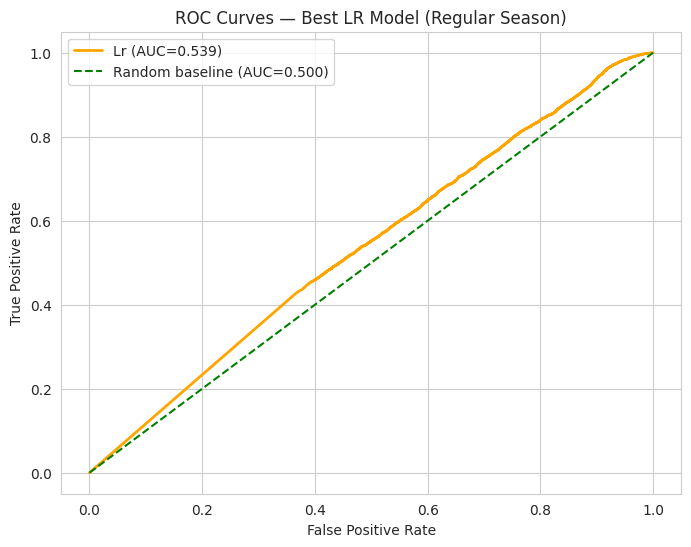

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/tmp/ipykernel_169009/4098004273.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()


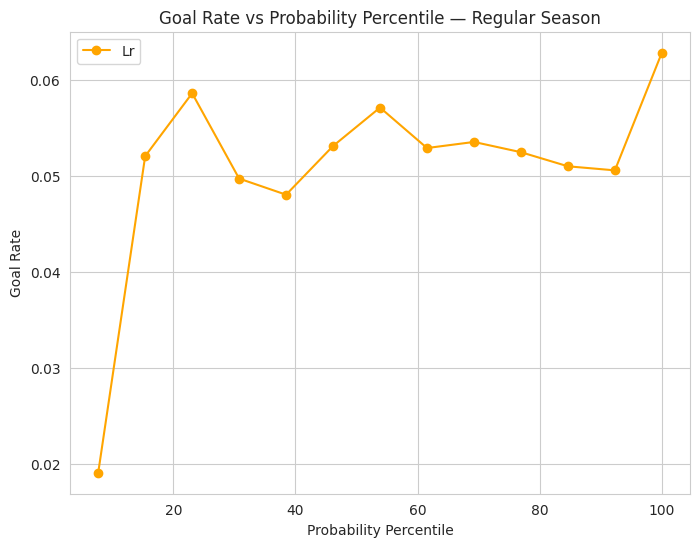

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


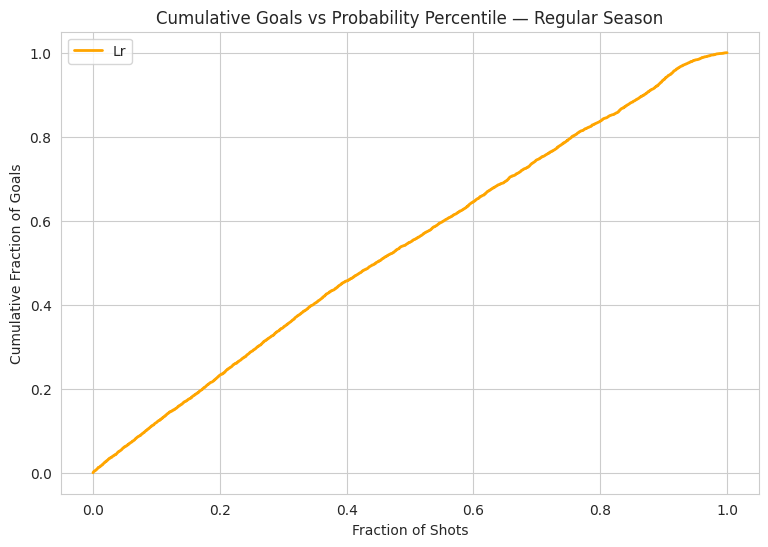

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


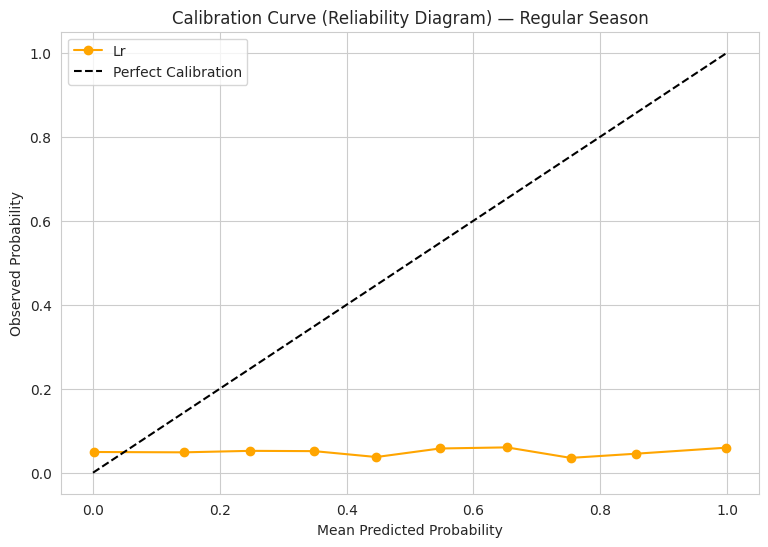


=== Evaluating LR Model on Playoffs ===


Missing values before handling: 68159
Missing values after handling: 0


/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


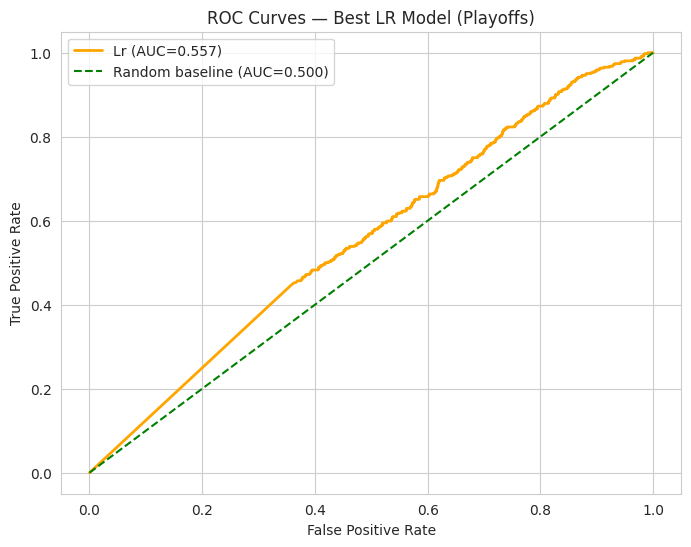

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/tmp/ipykernel_169009/4098004273.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()


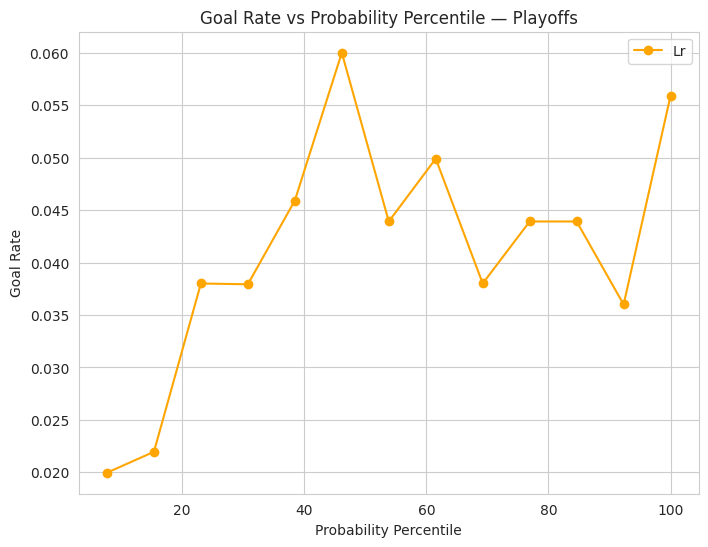

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


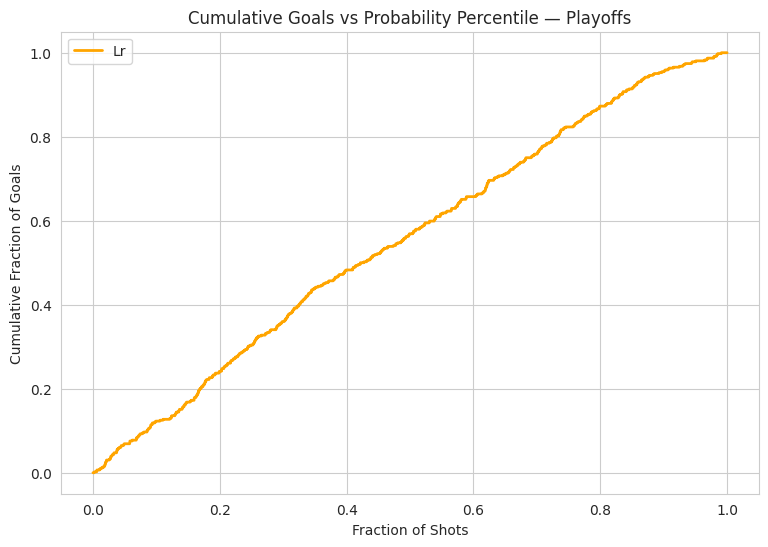

/home/sina/Desktop/UdeM/3rd Semester (Fall 2025)/Data Science/Project/Milestone 2/milestone-2-venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


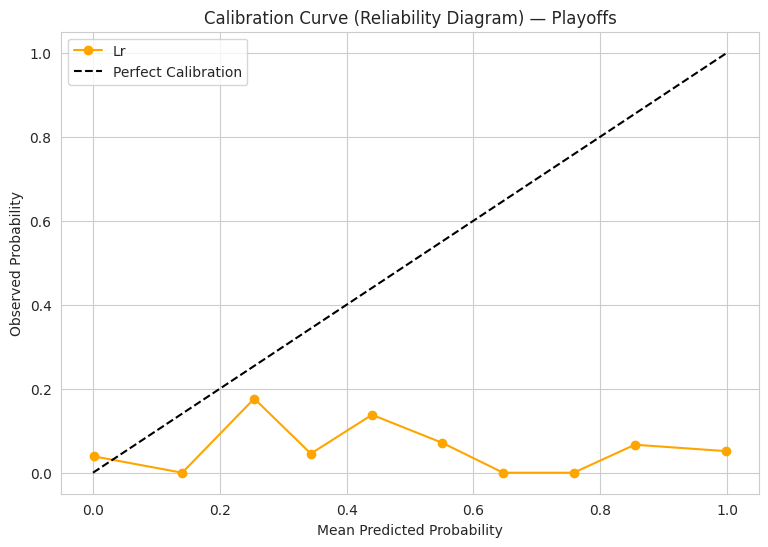


 Completed evaluation of all Logistic Regression models for both test sets.


In [58]:
# Evaluate Logistic Regression Models (2020–21 Regular + Playoff)

# 1. Setting the Style Grid
sns.set_style("whitegrid")

# 2. Initializing the W&B session to access the Log Reg model defined in section 3
wandb.login()
entity_name = "IFT6758-2025-B08"
project_name = "IFT6758-Milestone2"

run = wandb.init(
    entity=entity_name,
    project=project_name,
    name="Q7 - Evaluate Logistic Regression with Regularization Model"
)

# 3. Load pretrained Log Reg models defined in Section 3 from W&B artifacts
artifact_names = {
    "lr": f"{entity_name}/{project_name}/Section-6-Models:latest"
}

# 4. Defining Models
models = {}
# Defining key and artifact_path in artifact_names
for key, artifact_path in artifact_names.items():
    print(f"\n Downloading artifact: {artifact_path}")
    artifact = wandb.use_artifact(artifact_path, type="model")
    artifact_dir = artifact.download()
    # Extracting the relevant pkl_files
    pkl_files = [f for f in os.listdir(artifact_dir) if f == "best_lr_model.pkl"]
    if not pkl_files:
        raise FileNotFoundError(f"No .pkl file found in {artifact_dir}")
    # Defining model_file and models[key] for the original Log Reg models
    model_file = os.path.join(artifact_dir, pkl_files[0])
    models[key] = joblib.load(model_file)
    print(f" Loaded {key} model from {model_file}")

# 5 Loading and prepare the 2020–21 NHL dataset which was first defined in section 2 a)
df = test_final_df.copy()

# 6. Defining function prepare_shot_data which adds columns which makes data easier to evaluate
# Essentially we are replicating the tidy data steps up to section 3


# Defining test data frame
test_shots = tidy_data_updated_test.copy()

# 7. Separating Regular and Playoff Games
test_shots["game_id"] = test_shots["game_id"].astype(str).str.zfill(10)
# 8. Defining game_type based on game_id
test_shots["game_type"] = test_shots["game_id"].str[4:6]
# Defining reg_test and playoff_test
reg_test = test_shots[test_shots["game_type"] == "02"]
playoff_test = test_shots[test_shots["game_type"] == "03"]

print(f"\nRegular season samples: {len(reg_test)} | Playoff samples: {len(playoff_test)}")

# 9. Features
features = {
    "lr": optimal_features
}

# 10. Combining the plotting function
# Do not reuse plotting functions from section 3 due to pulling models from Wandb
def plot_combined_curves(models, X_dict, y_dict, label):
    colors = {
        "lr": "orange",
        "random": "green"
    }

    y_test = y_dict["lr"]

    # 11. Plotting the ROC Curve
    plt.figure(figsize=(8, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, color=colors[key], lw=2, label=f"{key.title()} (AUC={auc_score:.3f})")
    plt.plot([0, 1], [0, 1], "--", color=colors["random"], label="Random baseline (AUC=0.500)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — Best LR Model ({label})")
    plt.legend()
    wandb.log({f"ROC Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 12. Plotting the Goal Rate vs Probability Percentile
    plt.figure(figsize=(8, 6))
    # Iterate through models.keys()
    for key in models.keys():
        # Similar to section 3 curves, define y_proba, df_eval, rate, and other columns
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba})
        df_eval["percentile_bin"] = pd.qcut(df_eval["y_proba"], q=20, duplicates="drop")
        rate = df_eval.groupby("percentile_bin")["y"].mean().reset_index()
        rate["percentile_rank"] = (rate.index + 1) * (100 / len(rate))
        plt.plot(rate["percentile_rank"], rate["y"], marker="o", color=colors[key], label=key.title())
    plt.xlabel("Probability Percentile")
    plt.ylabel("Goal Rate")
    plt.title(f"Goal Rate vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Goal Rate Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 13. Defining Cumulative Goals similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        df_eval = pd.DataFrame({"y": y_test, "y_proba": y_proba}).sort_values("y_proba", ascending=False)
        df_eval["cum_goals"] = df_eval["y"].cumsum()
        df_eval["cum_goals_frac"] = df_eval["cum_goals"] / df_eval["y"].sum()
        df_eval["cum_shots_frac"] = np.arange(len(df_eval)) / len(df_eval)
        plt.plot(df_eval["cum_shots_frac"], df_eval["cum_goals_frac"], lw=2, color=colors[key], label=key.title())
    plt.xlabel("Fraction of Shots")
    plt.ylabel("Cumulative Fraction of Goals")
    plt.title(f"Cumulative Goals vs Probability Percentile — {label}")
    plt.legend()
    wandb.log({f"Cumulative Goals Combined — {label}": wandb.Image(plt)})
    plt.show()

    # 14. Plotting the Calibration Curve similar to function in section 3
    plt.figure(figsize=(9, 6))
    for key in models.keys():
        y_proba = models[key].predict_proba(X_dict[key])[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
        plt.plot(prob_pred, prob_true, "o-", color=colors[key], label=key.title())
    plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Observed Probability")
    plt.title(f"Calibration Curve (Reliability Diagram) — {label}")
    plt.legend()
    wandb.log({f"Calibration Combined — {label}": wandb.Image(plt)})
    plt.show()

# 15. Evaluating on the Regular and Playoff Data
for label, df_test in [("Regular Season", reg_test), ("Playoffs", playoff_test)]:
    print(f"\n=== Evaluating LR Model on {label} ===")
    run = wandb.init(entity=entity_name, project=project_name, name=f"Q7 - LR on {label}")

    # 16. Defining the evaluation
    X_dict, y_dict = {}, {}
    for key, model in models.items():
        current_features = features[key]
        # Handle missing values
        df_test = handle_missing_values(df_test)
        # Apply one-hot encoding to 'shot_type' and 'last_event_type'
        df_test = pd.get_dummies(df_test, columns=['last_event_type'], drop_first=True)
        # Applying Standad Scaler and fit transform 
        # scaler = StandardScaler()
        # X_scaled = scaler.transform(df_test[current_features].fillna(df_test[current_features].median()))
        X_scaled = df_test[current_features].fillna(df_test[current_features].median())
        # Defiing Features
        X_dict[key] = pd.DataFrame(X_scaled, columns=current_features)
        # Defining Target
        y_dict[key] = df_test["is_goal"]

    # 17. Plotting the combined features
    plot_combined_curves(models, X_dict, y_dict, label)
    run.finish()

print("\n Completed evaluation of all Logistic Regression models for both test sets.")